# **Cleaning and pre-processing**

### Importing the libraries and data

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from numpy.random import seed
seed(123)
%matplotlib inline
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
import catboost as cb
import shap

Load the data.

In [4]:
df = pd.read_csv('listings.csv')

In [5]:
df.head()

id                        listing_url       scrape_id last_scraped  \
0  1078  https://www.airbnb.com/rooms/1078  20190514155147   2019-05-14   
1  2265  https://www.airbnb.com/rooms/2265  20190514155147   2019-05-14   
2  5245  https://www.airbnb.com/rooms/5245  20190514155147   2019-05-14   
3  5456  https://www.airbnb.com/rooms/5456  20190514155147   2019-05-14   
4  5769  https://www.airbnb.com/rooms/5769  20190514155147   2019-05-14   

                                        name  \
0          *UT/Hyde Park Craftsman Apartment   
1            Zen-East in the Heart of Austin   
2        Green, Colorful, Clean &  Cozy home   
3  Walk to 6th, Rainey St and Convention Ctr   
4                             NW Austin Room   

                                             summary  \
0  This upstairs apartment is surrounded by trees...   
1  Zen East is situated in a vibrant & diverse mu...   
2                                                NaN   
3  Fabulous location for walking to Convention Ce...   
4                                                NaN   

                                               space  \
0  The garage apartment was built in the 1920s an...   
1  This colorful and clean 1923 house was complet...   
2  Situated in a vibrant & diverse multicultural ...   
3  Cute Private Studio apartment located in Willo...   
4  Looking for a comfortable inexpensive room to ...   

                                         description experiences_offered  \
0  This upstairs apartment is surrounded by trees...                none   
1  Zen East is situated in a vibrant & diverse mu...                none   
2  Situated in a vibrant & diverse multicultural ...                none   
3  Fabulous location for walking to Convention Ce...                none   
4  Looking for a comfortable inexpensive room to ...                none   

                               neighborhood_overview  ...  \
0  Hyde Park is close to downtown, UT, 6th street...  ...   
1                                                NaN  ...   
2                                                NaN  ...   
3  My neighborhood is ideally located if you want...  ...   
4  Quiet neighborhood with lots of trees and good...  ...   

  is_business_travel_ready          cancellation_policy  \
0                        f                     flexible   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f  strict_14_with_grace_period   
4                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                t   
4                             t                                t   

  calculated_host_listings_count  calculated_host_listings_count_entire_homes  \
0                              2                                            2   
1                              3                                            2   
2                              3                                            2   
3                              1                                            1   
4                              1                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             1   
2                                             1   
3                                             0   
4                                             1   

  calculated_host_listings_count_shared_rooms  reviews_per_month  \
0                                           0               1.70   
1                                           0               0.19   
2    

In [6]:
df.shape

(11792, 107)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Columns: 107 entries, id to geometry
dtypes: float64(24), int64(22), object(61)
memory usage: 9.6+ MB


In [8]:
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
geometry                                         object
Length: 107, dtype: object

In [9]:
df.isnull().sum().sum()

181238

In [10]:
column_headers = list(df.columns)
print(column_headers)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_hood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'hood', 'hood_cleansed', 'hood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', '

In [11]:
pd.set_option('display.max_columns', len(df.columns))
pd.set_option('display.max_rows', 107)
df.head()

id                        listing_url       scrape_id last_scraped  \
0  1078  https://www.airbnb.com/rooms/1078  20190514155147   2019-05-14   
1  2265  https://www.airbnb.com/rooms/2265  20190514155147   2019-05-14   
2  5245  https://www.airbnb.com/rooms/5245  20190514155147   2019-05-14   
3  5456  https://www.airbnb.com/rooms/5456  20190514155147   2019-05-14   
4  5769  https://www.airbnb.com/rooms/5769  20190514155147   2019-05-14   

                                        name  \
0          *UT/Hyde Park Craftsman Apartment   
1            Zen-East in the Heart of Austin   
2        Green, Colorful, Clean &  Cozy home   
3  Walk to 6th, Rainey St and Convention Ctr   
4                             NW Austin Room   

                                             summary  \
0  This upstairs apartment is surrounded by trees...   
1  Zen East is situated in a vibrant & diverse mu...   
2                                                NaN   
3  Fabulous location for walking to Convention Ce...   
4                                                NaN   

                                               space  \
0  The garage apartment was built in the 1920s an...   
1  This colorful and clean 1923 house was complet...   
2  Situated in a vibrant & diverse multicultural ...   
3  Cute Private Studio apartment located in Willo...   
4  Looking for a comfortable inexpensive room to ...   

                                         description experiences_offered  \
0  This upstairs apartment is surrounded by trees...                none   
1  Zen East is situated in a vibrant & diverse mu...                none   
2  Situated in a vibrant & diverse multicultural ...                none   
3  Fabulous location for walking to Convention Ce...                none   
4  Looking for a comfortable inexpensive room to ...                none   

                               neighborhood_overview  \
0  Hyde Park is close to downtown, UT, 6th street...   
1                                                NaN   
2                                                NaN   
3  My neighborhood is ideally located if you want...   
4  Quiet neighborhood with lots of trees and good...   

                                               notes  \
0  What to expect.    We really want you to have ...   
1  A 2013 Genuine Buddy Scooter 125 may be availa...   
2  Please note: A two story studio was built in t...   
3  Parking on street requires a permit.  There is...   
4                                                NaN   

                                             transit  \
0  We are 1 block from the 1 or 5 bus routes that...   
1  5 min walk to Capitol Metro Rail (train that t...   
2                                                NaN   
3  Bus stop around the block.  Uber, Lyft, Ride, ...   
4  We are approximately 16 miles from downtown Au...   

                                              access  \
0  Their own apartment and a large garden with se...   
1  Several local restaurants, small clubs, music ...   
2                                                NaN   
3                       Guests have access to patio.   
4                             Gravel Parking Kitchen   

                                         interaction  \
0  It is always a treat to meet guests at checkin...   
1  Depending on your dates and arrival time, I am...   
2  I should be available, upon your arrival, to a...   
3  I am happy to welcome my guests and show them in.   
4  We interact with our guests as little or as mu...   

                                         house_rules  thumbnail_url  \
0  Make yourself at home! * From 2:00 on the day ...            NaN   
1  • Check-in time is 4 pm. Check out is 11 am. I...            NaN   
2  A brief profile for all guests along with phot...            NaN   
3  No Pets allowed.  No smoking in the room. No m...            NaN   
4  I will need to see identification at check in....            NaN   

   medium_url         

In [12]:
df.describe(exclude=[np.number])

listing_url last_scraped  \
count                               11792        11792   
unique                              11792            1   
top     https://www.airbnb.com/rooms/1078   2019-05-14   
freq                                    1        11792   

                           name  \
count                     11791   
unique                    11600   
top     Wyndham Austin - Studio   
freq                          9   

                                                  summary  \
count                                               11459   
unique                                              10670   
top     Upscale 2-bedroom, 2-bath apartment with balco...   
freq                                                   38   

                                                    space  \
count                                                8876   
unique                                               8004   
top     Please make yourself at home and call us if yo...   
freq                                                   70   

                                              description experiences_offered  \
count                                               11691               11792   
unique                                              11157                   1   
top     Upscale 2-bedroom, 2-bath apartment with balco...                none   
freq                                                   19               11792   

       neighborhood_overview  \
count                   7666   
unique                  6594   
top                 Downtown   
freq                      43   

                                                    notes  \
count                                                5368   
unique                                               4583   
top     Guest Information Form must be completed withi...   
freq                                                   59   

                                                  transit  \
count                                                7473   
unique                                               6475   
top     Austin is a very connected city, with buses, b...   
freq                                                   72   

                                                   access  \
count                                                7422   
unique                                               6368   
top     You'll have access to the whole home, except a...   
freq                                                   78   

                                              interaction  \
count                                                7696   
unique                                               6464   
top     The Renters Club is available to you from 9am-...   
freq                                                   70   

                                              house_rules  \
count                                                7917   
unique                                               6606   
top     Guests must be over the age of 25 and will be ...   
freq                                                   85   

                                              picture_url  \
count                                               11792   
unique                                              11571   
top     https://a0.muscache.com/im/pictures/64c0a276-4...   
freq                                                   14   

                                           host_url    host_name  host_since  \
count                                         11792        11789       11789   
unique                                         8299         3024        2731   
top     https://www.airbnb.com/users/show/219500569  Stay Alfred  2017-02-28   
freq                                             79          143          85   

                       host_location  \
count                          11761   
unique                           420   
top     Austin, Texas, Unit

### **Dropping initial columns**

In [13]:
df.drop(['id','listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_hood', 'host_verifications', 'calendar_last_scraped'], axis = 1, inplace=True)

In [14]:
df.state.value_counts()

TX    11784
Tx        3
tx        2
Name: state, dtype: int64

Other columns can be dropped because they contain a majority of null entries.

In [15]:
df.isna().sum()

experiences_offered                                 0
host_since                                          3
host_response_time                               3530
host_response_rate                               3530
host_acceptance_rate                            11792
host_is_superhost                                   3
host_listings_count                                 3
host_total_listings_count                           3
host_has_profile_pic                                3
host_identity_verified                              3
street                                              0
hood                                              827
hood_cleansed                                       0
hood_group_cleansed                             11792
city                                                2
state                                               3
zipcode                                           112
market                                             24
smart_location              

In [16]:
df.drop(['host_acceptance_rate', 'hood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license'], axis = 1, inplace = True)

Some columns contain similar data, so, only one column may be kept and others be dropped, as they will be highly correlated.

In [17]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

3


experiences_offered host_since host_response_time host_response_rate  \
1572                 none        NaN                NaN                NaN   
2618                 none        NaN                NaN                NaN   
10386                none        NaN                NaN                NaN   

      host_is_superhost  host_listings_count  host_total_listings_count  \
1572                NaN                  NaN                        NaN   
2618                NaN                  NaN                        NaN   
10386               NaN                  NaN                        NaN   

      host_has_profile_pic host_identity_verified                     street  \
1572                   NaN                    NaN  Austin, TX, United States   
2618                   NaN                    NaN  Austin, TX, United States   
10386                  NaN                    NaN  Austin, TX, United States   

                  hood  hood_cleansed    city state  zipcode  market  \
1572    Travis Heights          78704  Austin    TX  78704.0  Austin   
2618   Pleasant Valley          78741  Austin    TX  78741.0  Austin   
10386    East Downtown          78702  Austin    TX  78702.0  Austin   

      smart_location country_code        country  latitude  longitude  \
1572      Austin, TX           US  United States  30.25560  -97.74707   
2618      Austin, TX           US  United States  30.22755  -97.72671   
10386     Austin, TX           US  United States  30.27917  -97.70996   

      is_location_exact property_type        room_type  accommodates  \
1572                  t     Apartment  Entire home/apt             2   
2618                  t     Apartment     Private room             1   
10386                 t         House  Entire home/apt             7   

       bathrooms  bedrooms  beds  bed_type  \
1572         1.0       1.0   1.0    Airbed   
2618         1.0       1.0   1.0  Real Bed   
10386        1.5       3.0   3.0  Real Bed   

                                               amenities    price  \
1572   {"Air conditioning","Wheelchair accessible",Po...   $75.00   
2618   {TV,"Cable TV",Internet,Wifi,"Air conditioning...   $26.00   
10386  {TV,Wifi,"Air conditioning",Kitchen,"Free park...  $109.00   

      security_deposit cleaning_fee  guests_included extra_people  \
1572               NaN          NaN                1        $0.00   
2618               NaN          NaN                1        $0.00   
10386              NaN          NaN                1        $0.00   

       minimum_nights  maximum_nights  minimum_minimum_nights  \
1572                1            1125                       1   
2618                1               5                       1   
10386               2            1125                       2   

       maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
1572                        1                    1125                    1125   
2618                        1                       5                       5   
10386                       2                    1125                    1125   

       minimum_nights_avg_ntm  maximum_nights_avg_ntm calendar_updated  \
1572                      1.0                  1125.0    44 months ago   
2618                      1.0                     5.0    42 months ago   
10386                     2.0                  1125.0     3 months ago   

      has_availability  availability_30  availability_60  availability_90  \
1572                 t                0                0                0   
2618                 t                0                0                0   
10386                t                0                0                0   

       availability_365  number_of_reviews  number_of_reviews_ltm  \
1572                  0                  1                      0   
2618                  0                  4                      0   
10386                 0                  4                    

In [18]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count',
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [19]:
lat_long = df[['latitude', 'longitude']]

In [20]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'state', 'city', 'market', 'hood_cleansed', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [21]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)


671

In [22]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

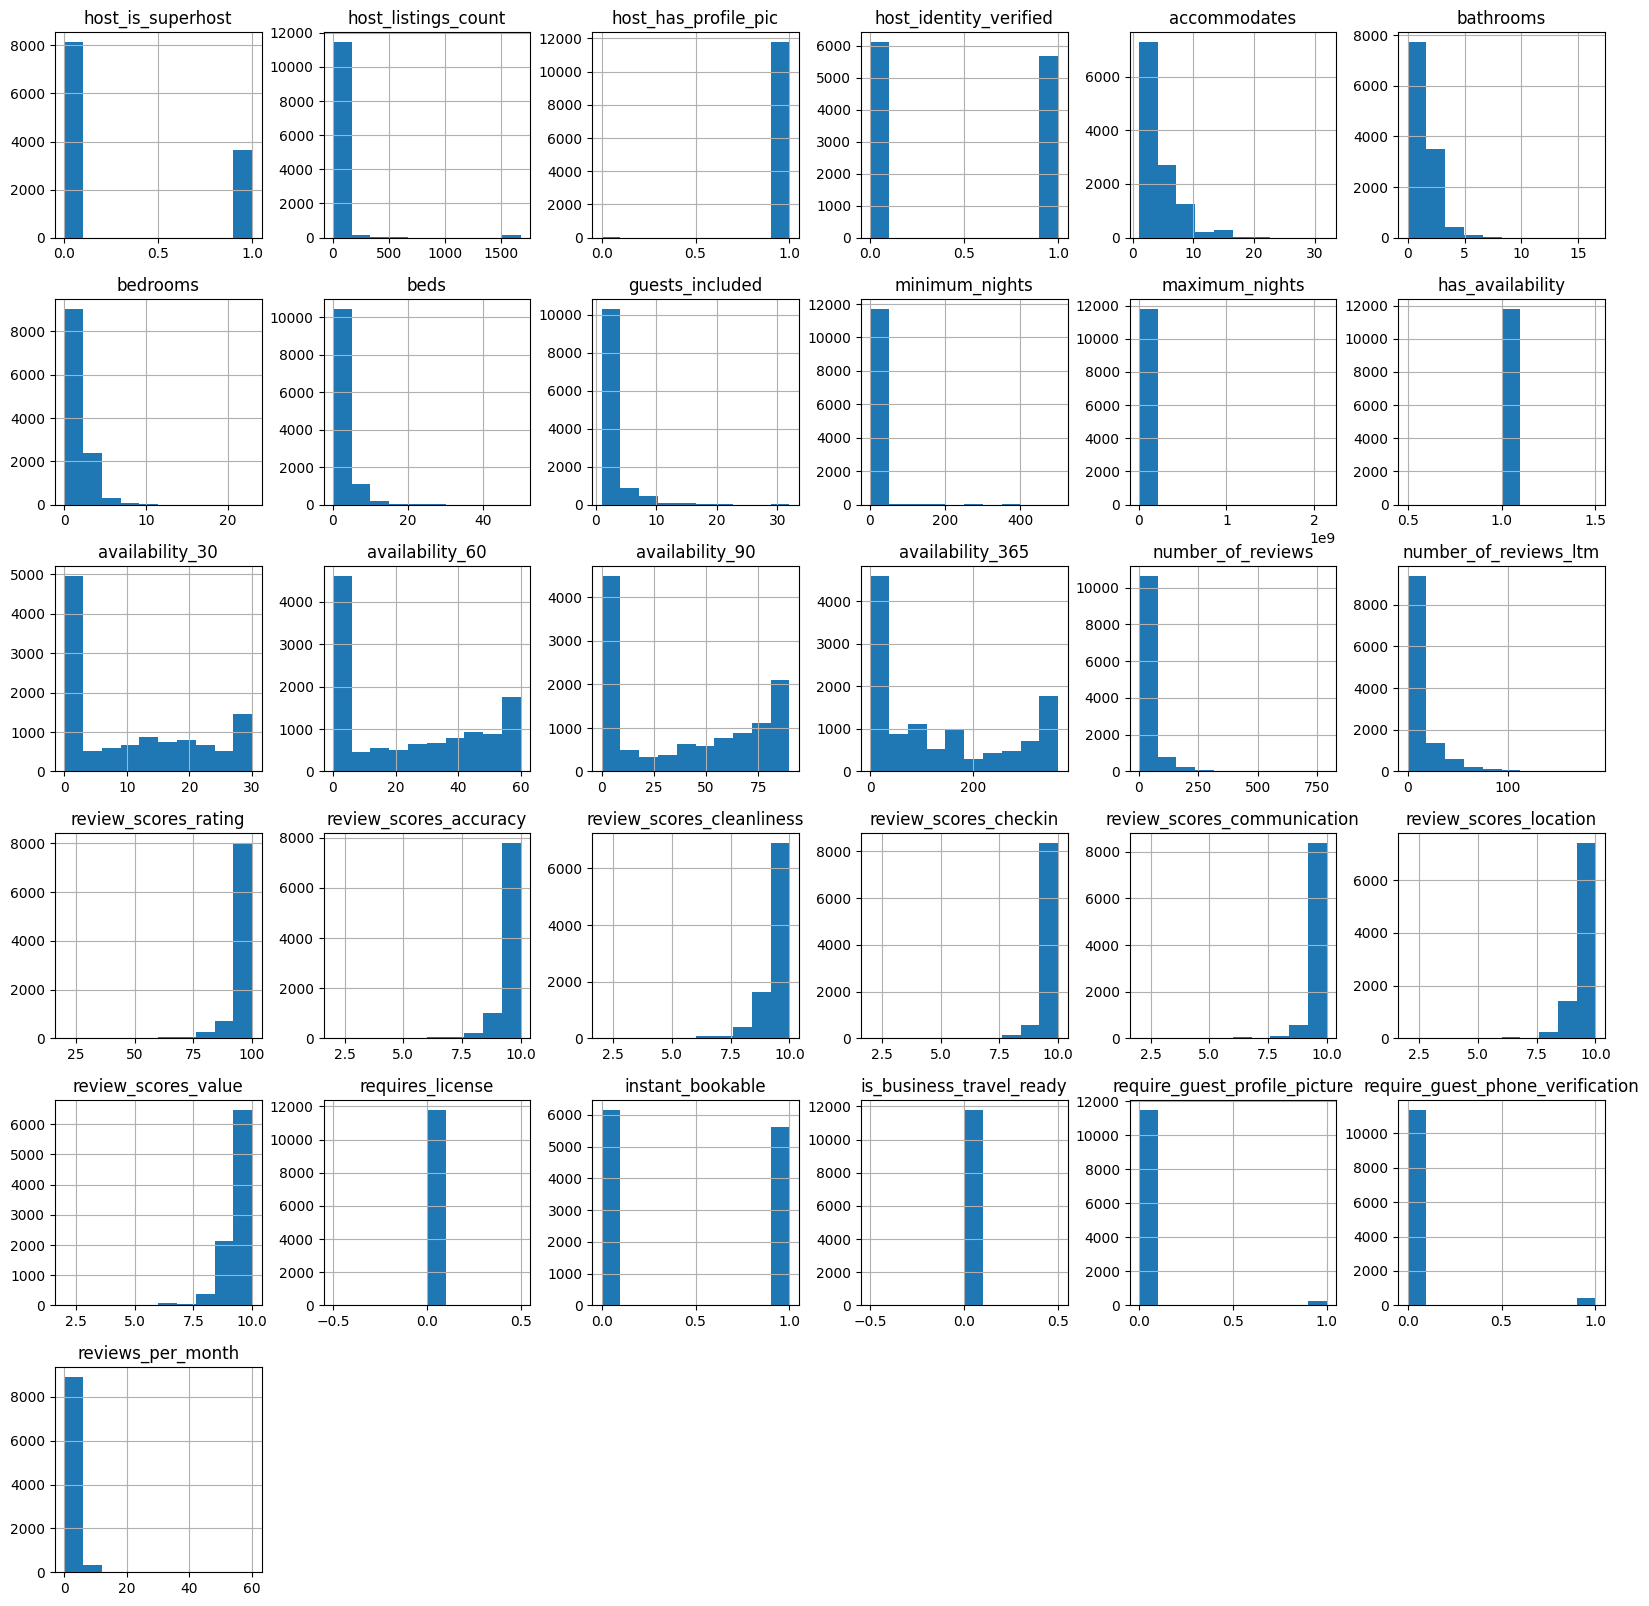

In [23]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [24]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

In [25]:
df.describe(exclude=[np.number])

experiences_offered  host_since host_response_time host_response_rate  \
count                11792       11789               8262               8262   
unique                   1        2731                  4                 46   
top                   none  2017-02-28     within an hour               100%   
freq                 11792          85               6320               6599   

                 hood property_type        room_type  bed_type amenities  \
count           10965         11792            11792     11792     11792   
unique             78            36                3         5     10876   
top     East Downtown         House  Entire home/apt  Real Bed        {}   
freq             1124          5670             8601     11642        68   

          price security_deposit cleaning_fee extra_people calendar_updated  \
count     11792             8308         9360        11792            11792   
unique      706              103          256           71               86   
top     $150.00            $0.00      $100.00        $0.00            today   
freq        432             2971          836         6938             2831   

       first_review last_review jurisdiction_names  \
count          9273        9273              11792   
unique         1791         927                  1   
top      2019-03-10  2019-05-05    {"Texas State"}   
freq             89         692              11792   

                cancellation_policy                    geometry  
count                         11792                       11792  
unique                            6                       11790  
top     strict_14_with_grace_period  POINT (-97.72354 30.25225)  
freq                           4486                           2

### Cleaning individual columns

Most listings offer no experiences so this feature can be dropped.

In [26]:
df.experiences_offered.value_counts()

none    11792
Name: experiences_offered, dtype: int64

Also, Most listings offer same jurisdiction_names so this feature can be dropped.

In [27]:
df.jurisdiction_names.value_counts()

{"Texas State"}    11792
Name: jurisdiction_names, dtype: int64

In [28]:
df.drop(['jurisdiction_names', 'experiences_offered', 'calendar_updated'], axis = 1, inplace = True)

**host_since**

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped ***(2023, 8, 18)***. The original column will be left in initially for EDA, and dropped later.

In [29]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since)

# Calculating the number of days
df['host_days_active'] = (datetime(2023, 8, 18) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 3102.0
Median days as host: 3078.0


Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [30]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 3530
Proportion: 29.9%


1566

In [31]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.535957
unknown               0.299355
within a few hours    0.091333
within a day          0.063009
a few days or more    0.010346
Name: host_response_time, dtype: float64

Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [32]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 3530
Proportion: 29.9%


In [33]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 96.0
Median host response rate: 100.0
Proportion of 100% host response rates: 79.9%


In [34]:
#split a column-values into 4 parts
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100],
                               labels=['0-49%', '50-89%', '90-99%', '100%'],
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       6599
unknown    3530
50-89%      890
90-99%      590
0-49%       183
Name: host_response_rate, dtype: int64

In [35]:
df.describe(exclude=[np.number], datetime_is_numeric=True)

host_since host_response_time host_response_rate  \
count                           11789              11792              11792   
unique                            NaN                  5                  5   
top                               NaN     within an hour               100%   
freq                              NaN               6320               6599   
mean    2015-02-18 14:45:48.935448064                NaN                NaN   
min               2008-03-03 00:00:00                NaN                NaN   
25%               2013-07-05 00:00:00                NaN                NaN   
50%               2015-03-15 00:00:00                NaN                NaN   
75%               2016-10-19 00:00:00                NaN                NaN   
max               2019-05-13 00:00:00                NaN                NaN   

                 hood property_type        room_type  bed_type amenities  \
count           10965         11792            11792     11792     11792   
unique             78            36                3         5     10876   
top     East Downtown         House  Entire home/apt  Real Bed        {}   
freq             1124          5670             8601     11642        68   
mean              NaN           NaN              NaN       NaN       NaN   
min               NaN           NaN              NaN       NaN       NaN   
25%               NaN           NaN              NaN       NaN       NaN   
50%               NaN           NaN              NaN       NaN       NaN   
75%               NaN           NaN              NaN       NaN       NaN   
max               NaN           NaN              NaN       NaN       NaN   

          price security_deposit cleaning_fee extra_people first_review  \
count     11792             8308         9360        11792         9273   
unique      706              103          256           71         1791   
top     $150.00            $0.00      $100.00        $0.00   2019-03-10   
freq        432             2971          836         6938           89   
mean        NaN              NaN          NaN          NaN          NaN   
min         NaN              NaN          NaN          NaN          NaN   
25%         NaN              NaN          NaN          NaN          NaN   
50%         NaN              NaN          NaN          NaN          NaN   
75%         NaN              NaN          NaN          NaN          NaN   
max         NaN              NaN          NaN          NaN          NaN   

       last_review          cancellation_policy                    geometry  
count         9273                        11792                       11792  
unique         927                            6                       11790  
top     2019-05-05  strict_14_with_grace_period  POINT (-97.72354 30.25225)  
freq           692                         4486                           2  
mean           NaN                          NaN                         NaN  
min            NaN                          NaN                         NaN  
25%            NaN                          NaN                         NaN  
50%            NaN                          NaN                         NaN  
75%            NaN                          NaN                         NaN  
max            NaN                          NaN                         NaN

**property_type**

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [36]:
df.property_type.value_counts()

House                     5670
Apartment                 2904
Condominium                863
Guesthouse                 483
Townhouse                  415
Bungalow                   362
Guest suite                250
Serviced apartment         168
Loft                       136
Camper/RV                   94
Cottage                     64
Tiny house                  54
Villa                       51
Other                       49
Bed and breakfast           49
Cabin                       30
Resort                      29
Hostel                      21
Tent                        14
Aparthotel                  13
Boutique hotel              12
Farm stay                   10
Boat                         9
Campsite                     9
Yurt                         6
Tipi                         5
Hotel                        4
Treehouse                    3
Barn                         3
Dome house                   3
Houseboat                    3
Chalet                       2
Bus     

In [37]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

**bathrooms, bedrooms and beds**

Missing values will be replaced with the median (to avoid strange fractions).

In [38]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

**bed_type**

Most listings have the same bed type so this feature can be dropped.

In [39]:
df.bed_type.value_counts()

Real Bed         11642
Futon               60
Airbed              52
Pull-out Sofa       26
Couch               12
Name: bed_type, dtype: int64

In [40]:
df.drop('bed_type', axis=1, inplace=True)

**amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [41]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,Internet,Wifi,"Air conditioning",Kitchen,"Free parking on premises",Heating,"Smoke detector",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Self check-in",Keypad}'],
      dtype=object)

In [42]:
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 

In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed'). Based on previous experience working in the Airbnb property management industry, and research into which amenities are considered by guests to be more important, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

In [43]:
column_headers = len(list(df.columns))
print(column_headers)

41


The amenities chosen are:

In [44]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [45]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,42:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'nature_and_views', 'host_greeting', 'smoking_allowed']


In [46]:
df.price.isna().sum()

0

**price**

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [47]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

**security_deposit**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

Having a missing value for security deposit is functionally the same as having a security deposit of $0, so missing values will be replaced with 0.

In [48]:
df.security_deposit.isna().sum()

3484

In [49]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

**cleaning_fee**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of $0, so missing values will be replaced with 0.

In [50]:
df.cleaning_fee.isna().sum()

2432

In [51]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**extra_people**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of $0, so missing values will be replaced with 0.

In [52]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

**availability**

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days.

In [53]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

**first_review and last_review**

About a quarter of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model workable to predict prices for any Airbnb listing, including brand new listings, it is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

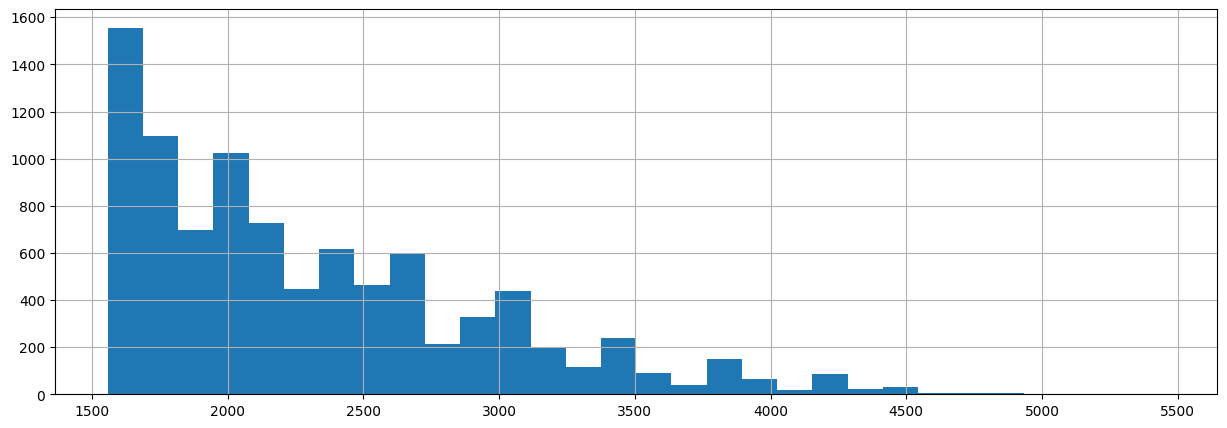

In [54]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2023, 8, 18) - df.first_review).astype('timedelta64[D]')
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [55]:

def bin_column(col, bins, labels, na_label='unknown'):

    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [56]:
# splitting time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

In [57]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2023, 8, 18) - df.last_review).astype('timedelta64[D]')

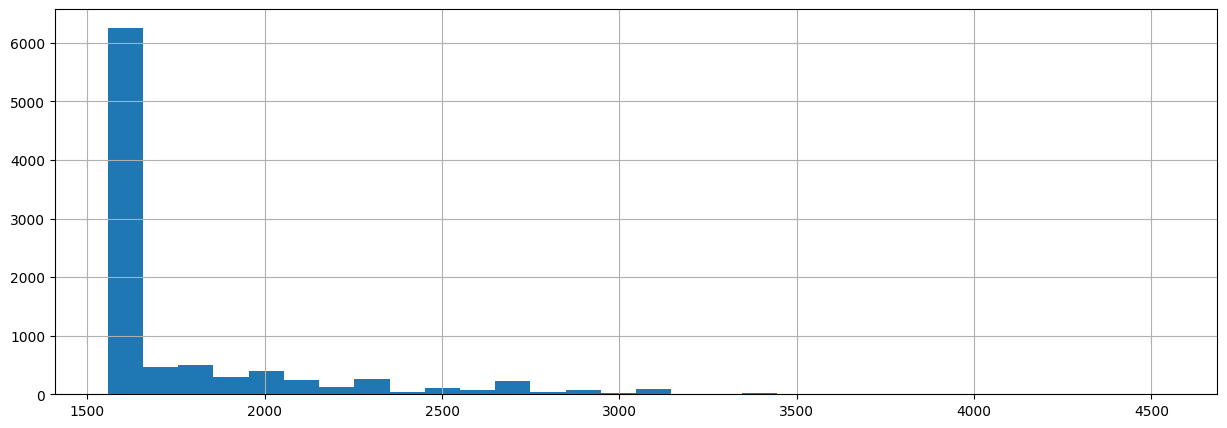

In [58]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [59]:
# splitting time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [60]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins.

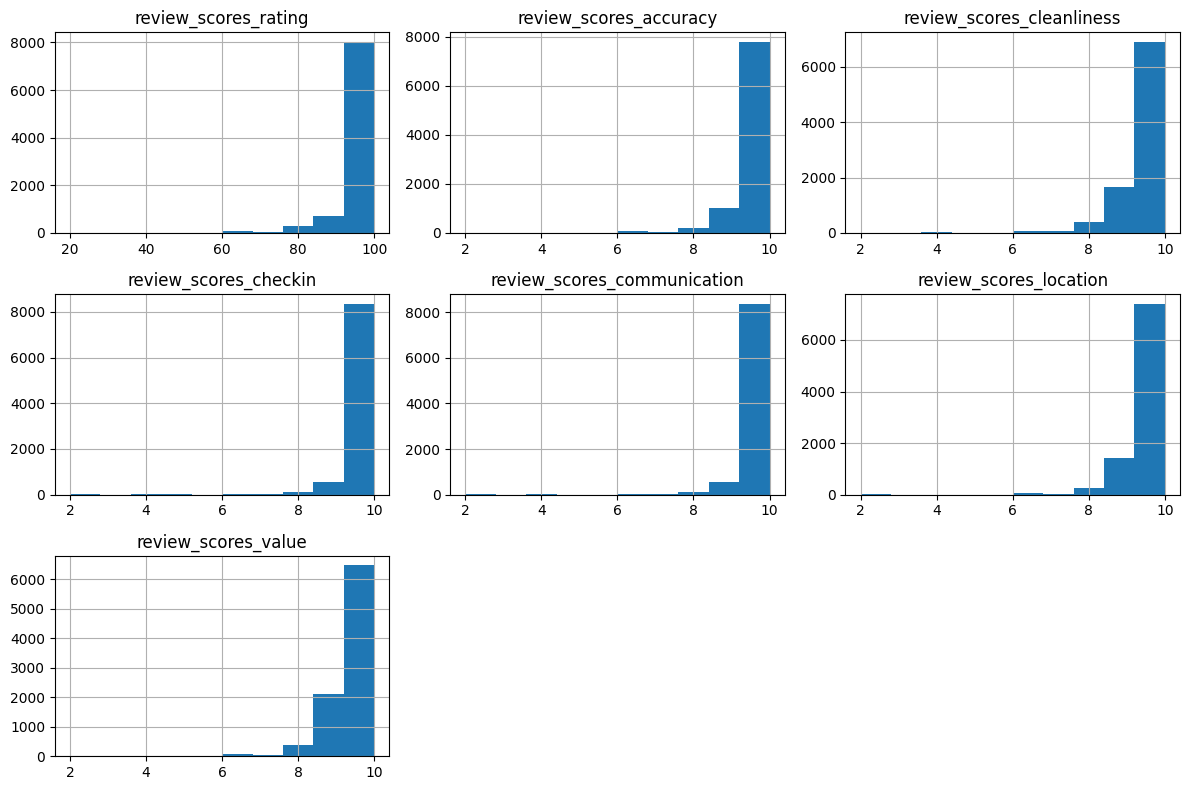

In [61]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

The majority of ratings are 9 or 10 out of 10, as also seen in the histograms above.
Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be grouped together.

In [62]:
variables_to_plot.pop(0) #the only column that is not out of 10 -> review scores rating

for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [63]:
df.describe(exclude=[np.number], datetime_is_numeric=True)

host_since host_response_time host_response_rate  \
count                           11789              11792              11792   
unique                            NaN                  5                  5   
top                               NaN     within an hour               100%   
freq                              NaN               6320               6599   
mean    2015-02-18 14:45:48.935448064                NaN                NaN   
min               2008-03-03 00:00:00                NaN                NaN   
25%               2013-07-05 00:00:00                NaN                NaN   
50%               2015-03-15 00:00:00                NaN                NaN   
75%               2016-10-19 00:00:00                NaN                NaN   
max               2019-05-13 00:00:00                NaN                NaN   

                 hood property_type        room_type  \
count           10965         11792            11792   
unique             78             3                3   
top     East Downtown         House  Entire home/apt   
freq             1124          6619             8601   
mean              NaN           NaN              NaN   
min               NaN           NaN              NaN   
25%               NaN           NaN              NaN   
50%               NaN           NaN              NaN   
75%               NaN           NaN              NaN   
max               NaN           NaN              NaN   

                         first_review review_scores_rating  \
count                            9273                11792   
unique                            NaN                    4   
top                               NaN           95-100/100   
freq                              NaN                 6829   
mean    2017-04-23 22:13:46.916855296                  NaN   
min               2008-09-13 00:00:00                  NaN   
25%               2016-03-19 00:00:00                  NaN   
50%               2017-10-15 00:00:00                  NaN   
75%               2018-10-07 00:00:00                  NaN   
max               2019-05-13 00:00:00                  NaN   

       review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
count                   11792                     11792                 11792   
unique                      4                         4                     4   
top                     10/10                     10/10                 10/10   
freq                     7795                      6902                  8364   
mean                      NaN                       NaN                   NaN   
min                       NaN                       NaN                   NaN   
25%                       NaN                       NaN                   NaN   
50%                       NaN                       NaN                   NaN   
75%                       NaN                       NaN                   NaN   
max                       NaN                       NaN                   NaN   

       review_scores_communication review_scores_location review_scores_value  \
count                        11792                  11792               11792   
unique                           4                      4                   4   
top                          10/10                  10/10               10/10   
freq                          8382                   7414                6480   
mean                           NaN                    NaN                 NaN   
min                            NaN                    NaN                 NaN   
25%                            NaN                    NaN                 NaN   
50%                            NaN                    NaN                 NaN   
75%                            NaN                    NaN                 NaN   
max                            NaN                    NaN                 NaN   

                cancellation_policy                    geometry  \
count 

In [64]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    4486
flexible                       3813
moderate                       3257
super_strict_30                 225
super_strict_60                   7
strict                            4
Name: cancellation_policy, dtype: int64

**cancellation_policy**

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [65]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [66]:
column_headers = list(df.columns)
print(column_headers)
print(len(column_headers))

['host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'hood', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_90', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'reviews_per_month', 'geometry', 'host_days_active', 'check_in_24h', 'air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly', 'parking', 'outdoor_space', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed', 'private_entrance', 'secure', 'se

**number_of_reviews_ltm and reviews_per_month**

These will be highly correlated with number_of_reviews and so will be dropped.

In [67]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   host_since                   11789 non-null  datetime64[ns]
 1   host_response_time           11792 non-null  object        
 2   host_response_rate           11792 non-null  object        
 3   host_is_superhost            11789 non-null  float64       
 4   host_listings_count          11789 non-null  float64       
 5   host_identity_verified       11789 non-null  float64       
 6   hood                         10965 non-null  object        
 7   property_type                11792 non-null  object        
 8   room_type                    11792 non-null  object        
 9   accommodates                 11792 non-null  int64         
 10  bathrooms                    11792 non-null  float64       
 11  bedrooms                     11792 non-nu

**Save cleaned Dataset**

Save the cleaned data set, in case it was needed to use it again.


In [69]:
#Save cleaned Dataset
with open('Cleaned_df', 'wb') as f:
    pickle.dump(df, f)

# **Exploratory data analysis**

### Read Cleaned Dataset

In [70]:
with open('Cleaned_df', 'rb') as f:
    df = pickle.load(f)
df

host_since  host_response_time host_response_rate  host_is_superhost  \
0     2013-01-08      within an hour               100%                1.0   
1     2008-08-23  within a few hours               100%                1.0   
2     2008-08-23  within a few hours               100%                1.0   
3     2009-02-16  within a few hours               100%                1.0   
4     2009-02-19      within an hour               100%                1.0   
...          ...                 ...                ...                ...   
11787 2019-05-13             unknown            unknown                0.0   
11788 2015-11-10             unknown            unknown                0.0   
11789 2017-06-11             unknown            unknown                0.0   
11790 2019-05-01             unknown            unknown                0.0   
11791 2010-10-01             unknown            unknown                0.0   

       host_listings_count  host_identity_verified                 hood  \
0                      3.0                     1.0  University of Texas   
1                      3.0                     1.0        East Downtown   
2                      3.0                     1.0        East Downtown   
3                      1.0                     1.0        East Downtown   
4                      1.0                     1.0    SW Williamson Co.   
...                    ...                     ...                  ...   
11787                  1.0                     0.0               Zilker   
11788                  2.0                     1.0              Hancock   
11789                  2.0                     0.0                  NaN   
11790                  1.0                     0.0       South Congress   
11791                  1.0                     1.0  University of Texas   

      property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0             Other  Entire home/apt             2        1.0       1.0   1.0   
1             House  Entire home/apt             4        2.0       2.0   2.0   
2             House     Private room             2        1.0       1.0   1.0   
3             Other  Entire home/apt             3        1.0       1.0   2.0   
4             House     Private room             2        1.0       1.0   1.0   
...             ...              ...           ...        ...       ...   ...   
11787         House     Private room             2        1.0       1.0   1.0   
11788     Apartment     Private room             1        1.0       1.0   1.0   
11789         House     Private room             1        1.5       1.0   1.0   
11790     Apartment  Entire home/apt             3        1.0       1.0   2.0   
11791     Apartment  Entire home/apt             2        1.0       1.0   1.0   

       price  security_deposit  cleaning_fee  guests_included  extra_people  \
0         85                 0            35                2           125   
1        225               500           100                4            30   
2        100               500            75                2            35   
3         95               100             0                2            45   
4         40                 0             0                2             0   
...      ...               ...           ...              ...           ...   
11787    150                 0             0                1             0   
11788     29                 0             0                1             0   
11789     30                 0             0                1             0   
11790    115                 0            50                2            25   
11791     90                 0             0                1             0   

       minimum_nights  maximum_nights  availability_90  number_of_reviews  \
0                   2             365               26                221   
1                  28             183               56                 24   
2              

**Time Series**

Time is an important factor to consider in a model when we wish to predict prices or trends. Enter time series. A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future. There are also other questions that come to play when dealing with time series. For example: Is there any seasonality to the price? Is it stationary? Even though we may not be able to include this aspect into our model, it is good to explore it to be aware of it and be able to make recommendations for future research. Thus, in this section, we will explore this aspect of the data.

A high level of seasonality is evident, with notable peaks at the beginning of each year when people put properties online to take advantage of the increased number of tourists in the New Year holidays.

In [71]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 03 March 2008, and the most recent joined on 13 May 2019.


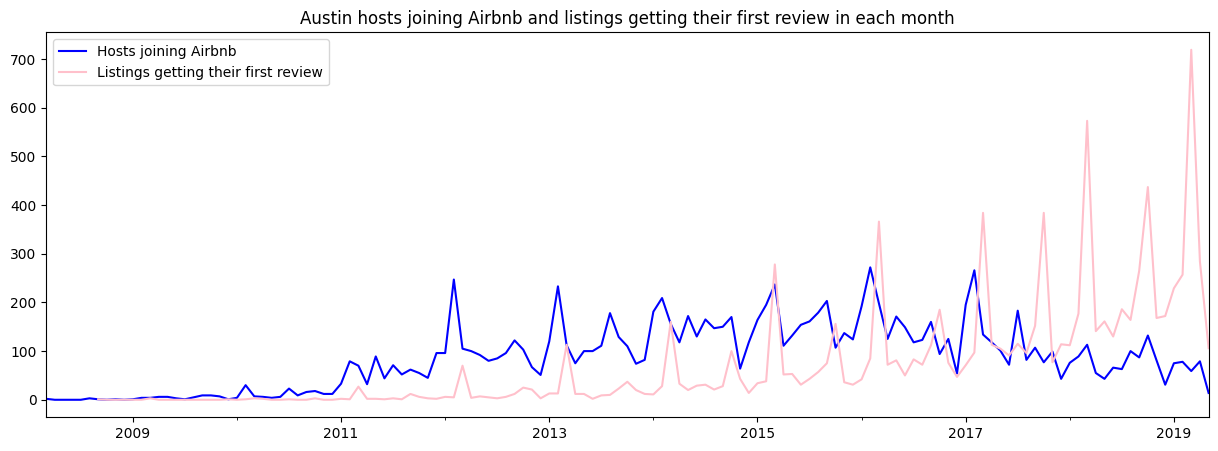

In [72]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='blue')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='pink')
plt.title('Austin hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-03-03', '2019-05-13') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [73]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [74]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)

    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

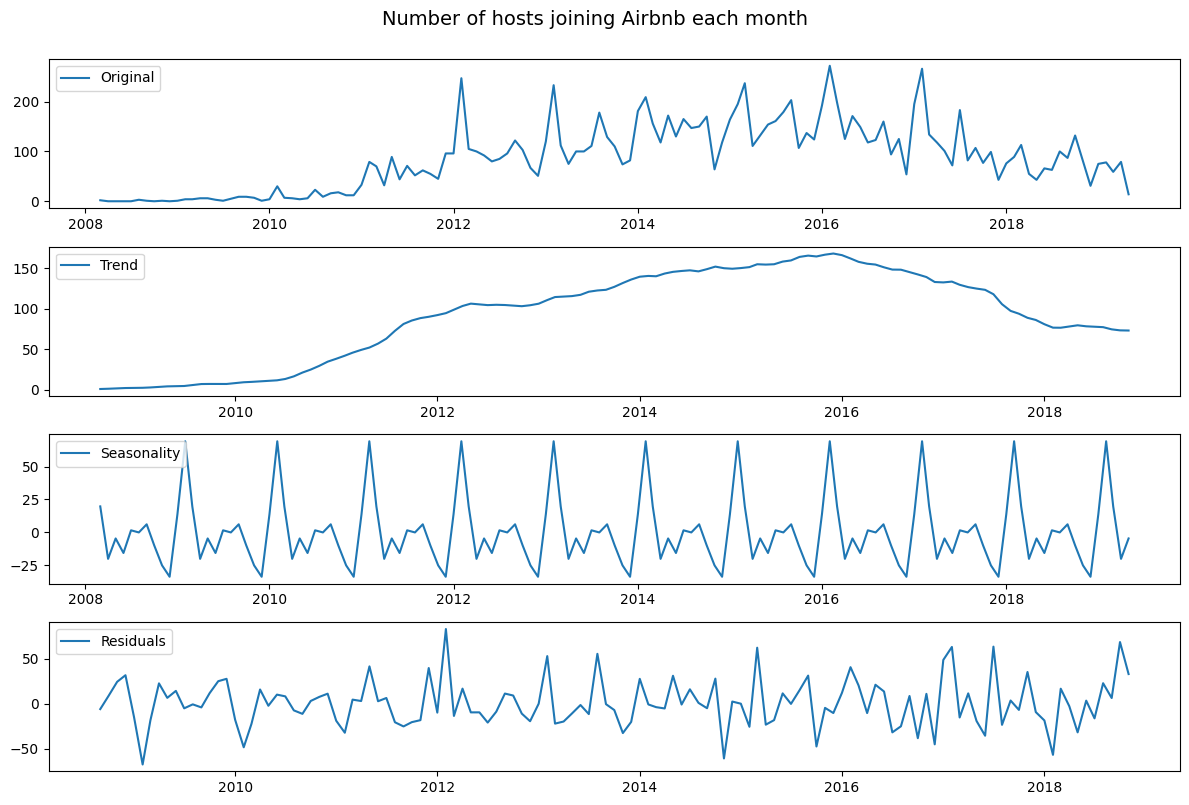

In [75]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

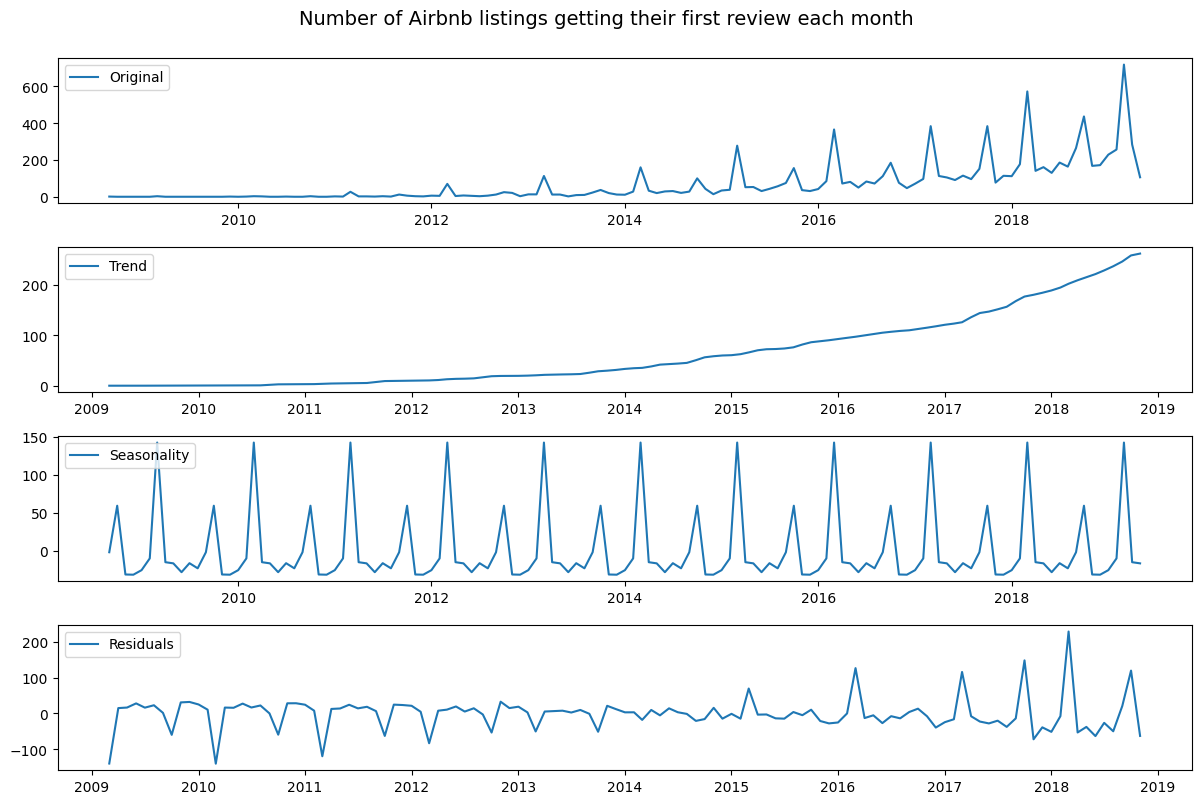

In [76]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

As seen above, there is a clear seasonality. Every year, you see a peak in hosts joining at the beginning of the year (new-year holidays), and the lowest points are at the end of each year.

**host_listings_count**

Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

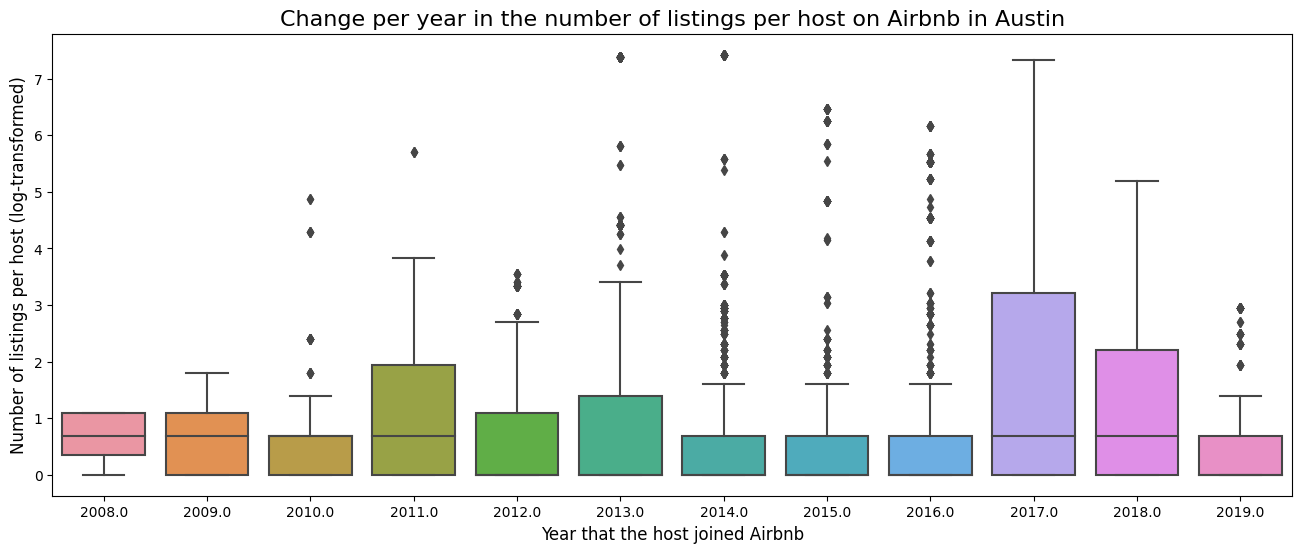

In [79]:
plt.figure(figsize=(16, 6))
hostsince = df.host_since.dt.year
hostlistingcount = np.log(df.host_listings_count)
sns.boxplot(x=hostsince, y=hostlistingcount)
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Austin', fontsize=16)
plt.show()

In [80]:
print("Average number of listings per host per year on Airbnb in Austin:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Austin:
host_since
2008-01-01     2.14
2009-01-01     2.21
2010-01-01     6.19
2011-01-01     8.00
2012-01-01     3.44
2013-01-01    89.92
2014-01-01    25.81
2015-01-01    12.17
2016-01-01    16.29
2017-01-01    98.26
2018-01-01    16.50
2019-01-01     3.42
Name: host_listings_count, dtype: float64


In [81]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
5650  2017-04-03                314.0
7243  2013-10-08                332.0
7324  2015-04-14                349.0
7272  2016-10-21                472.0
7299  2015-11-16                516.0
11600 2015-04-07                641.0
8147  2017-02-01               1522.0
8171  2013-02-04               1614.0
10029 2014-01-03               1677.0
10386        NaT                  NaN

divide by zero encountered in log


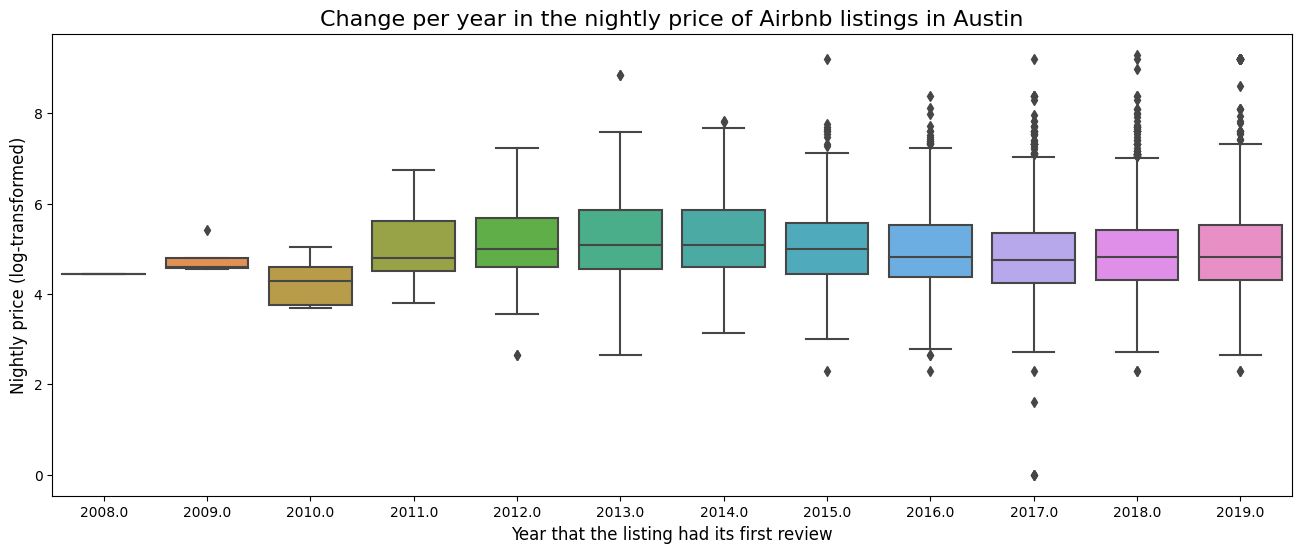

In [82]:
plt.figure(figsize=(16,6))
sns.boxplot(x=df.first_review.dt.year, y=np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Austin', fontsize=16)
plt.show()

In [83]:
print("Mean nightly price of listings in each year on Airbnb in Austin:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Austin:
first_review
2008-01-01     85.00
2009-01-01    129.75
2010-01-01     78.40
2011-01-01    202.76
2012-01-01    251.06
2013-01-01    311.51
2014-01-01    289.39
2015-01-01    244.19
2016-01-01    226.92
2017-01-01    225.43
2018-01-01    237.83
2019-01-01    514.67
Name: price, dtype: float64


In [84]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
5650  2017-04-03                314.0
7243  2013-10-08                332.0
7324  2015-04-14                349.0
7272  2016-10-21                472.0
7299  2015-11-16                516.0
11600 2015-04-07                641.0
8147  2017-02-01               1522.0
8171  2013-02-04               1614.0
10029 2014-01-03               1677.0
10386        NaT                  NaN

divide by zero encountered in log


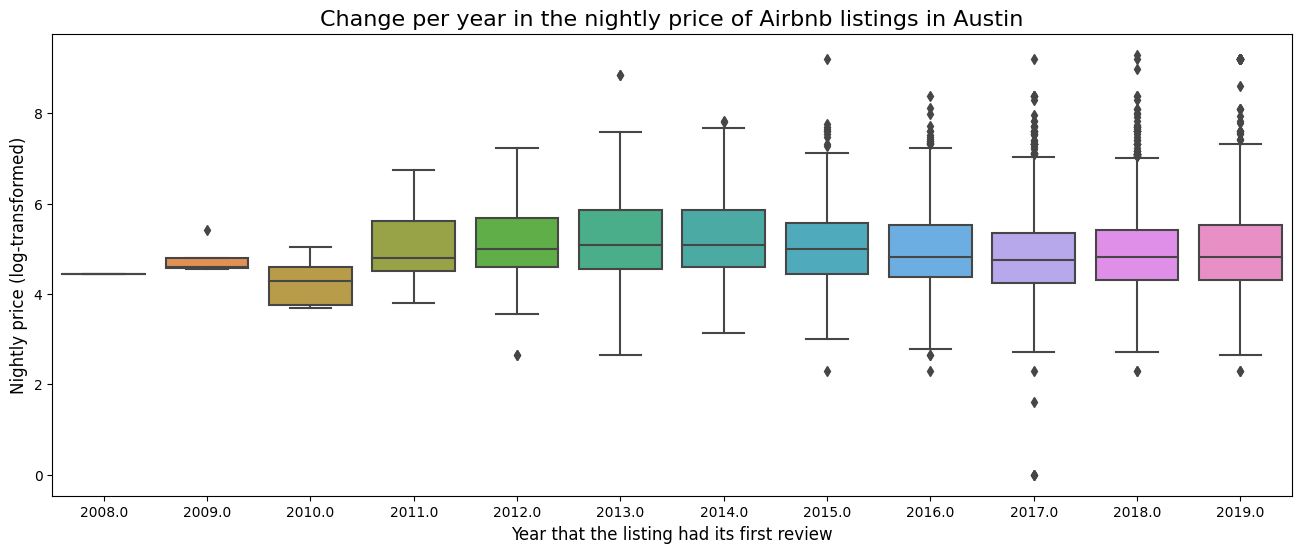

In [86]:
plt.figure(figsize=(16,6))
sns.boxplot(x=df.first_review.dt.year, y=np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Austin', fontsize=16)
plt.show()

In [87]:
print("Mean nightly price of listings in each year on Airbnb in Austin:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Austin:
first_review
2008-01-01     85.00
2009-01-01    129.75
2010-01-01     78.40
2011-01-01    202.76
2012-01-01    251.06
2013-01-01    311.51
2014-01-01    289.39
2015-01-01    244.19
2016-01-01    226.92
2017-01-01    225.43
2018-01-01    237.83
2019-01-01    514.67
Name: price, dtype: float64


In [88]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [89]:
df.describe()

host_is_superhost  host_listings_count  host_identity_verified  \
count       11789.000000         11789.000000            11789.000000   
mean            0.309611            33.840444                0.481720   
std             0.462353           190.751678                0.499687   
min             0.000000             0.000000                0.000000   
25%             0.000000             1.000000                0.000000   
50%             0.000000             1.000000                0.000000   
75%             1.000000             3.000000                1.000000   
max             1.000000          1677.000000                1.000000   

       accommodates     bathrooms      bedrooms          beds         price  \
count  11792.000000  11792.000000  11792.000000  11792.000000  11792.000000   
mean       4.627714      1.543207      1.792826      2.512636    337.985414   
std        3.132010      0.881627      1.267833      2.326502    853.709939   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      1.000000      1.000000     80.000000   
50%        4.000000      1.000000      1.000000      2.000000    149.000000   
75%        6.000000      2.000000      2.000000      3.000000    300.000000   
max       32.000000     16.500000     23.000000     50.000000  13229.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      11792.000000  11792.000000     11792.000000  11792.000000   
mean         214.724898     67.183853         2.360923     13.521286   
std          476.714126     94.435314         2.556161     27.179621   
min            0.000000      0.000000         1.000000      0.000000   
25%            0.000000      0.000000         1.000000      0.000000   
50%            0.000000     50.000000         1.000000      0.000000   
75%          250.000000    100.000000         2.000000     20.000000   
max         5100.000000   1703.000000        32.000000    500.000000   

       minimum_nights  maximum_nights  availability_90  number_of_reviews  \
count    11792.000000    1.179200e+04     11792.000000       11792.000000   
mean         4.410109    1.827345e+05        38.511703          26.540451   
std         16.201394    1.977589e+07        35.196752          53.797234   
min          1.000000    1.000000e+00         0.000000           0.000000   
25%          1.000000    2.700000e+01         0.000000           1.000000   
50%          2.000000    1.125000e+03        39.000000           6.000000   
75%          2.000000    1.125000e+03        73.000000          27.000000   
max        500.000000    2.147484e+09        90.000000         789.000000   

       instant_bookable  host_days_active  check_in_24h  air_conditioning  \
count      11792.000000      11792.000000  11792.000000      11792.000000   
mean           0.477612       3102.378647      0.165027          0.981258   
std            0.499520        794.250541      0.371221          0.135616   
min            0.000000       1558.000000      0.000000          0.000000   
25%            0.000000       2494.000000      0.000000          1.000000   
50%            0.000000       3078.000000      0.000000          1.000000   
75%            1.000000       3695.250000      0.000000          1.000000   
max            1.000000       5646.000000      1.000000          1.000000   

                bbq      balcony     bed_linen     breakfast            tv  \
count  11792.000000  11792.00000  11792.000000  11792.000000  11792.000000   
mean       0.155190      0.26713      0.327765      0.147558      0.836584   
std        0.362101      0.44248      0.469418      0.354676      0.369760   
min        0.000000      0.00000      0.000000      0.000000      0.000000   
25%        0.000000      0.00000      0.000000      0.000000      1.000000   
50%        0.000000      0.00000      0.000000      0.000000      1.000000   
75%        0.000000      1.00000      1.000000      0.

Looking at price distribution, advertised prices range from 0 to $13229. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

In [90]:
print(f"Nightly advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Nightly advertised prices range from $0 to $13229.


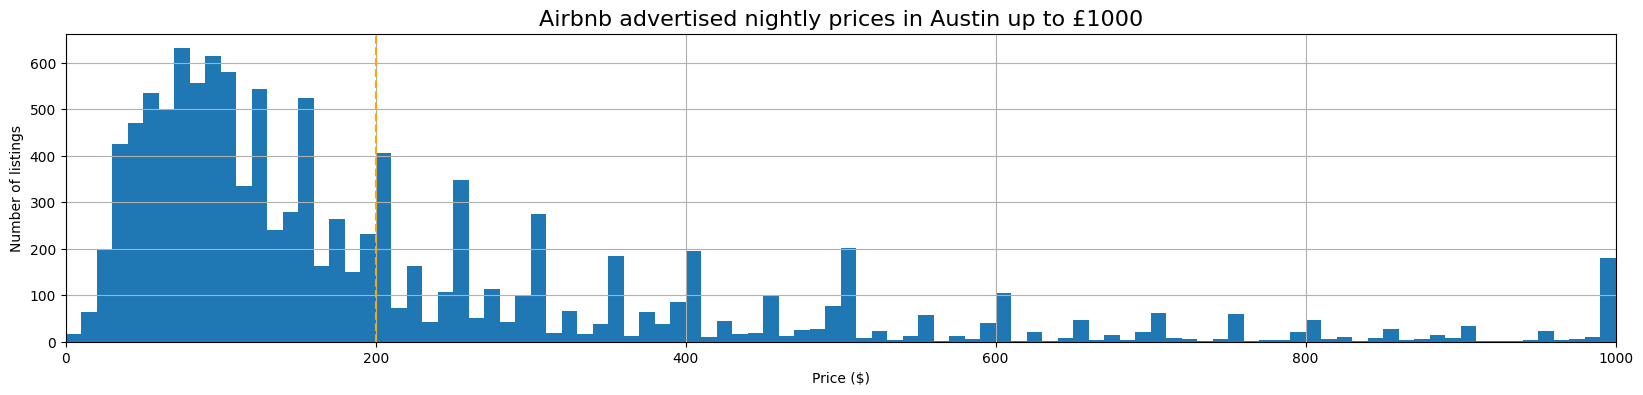

In [91]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Austin up to £1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

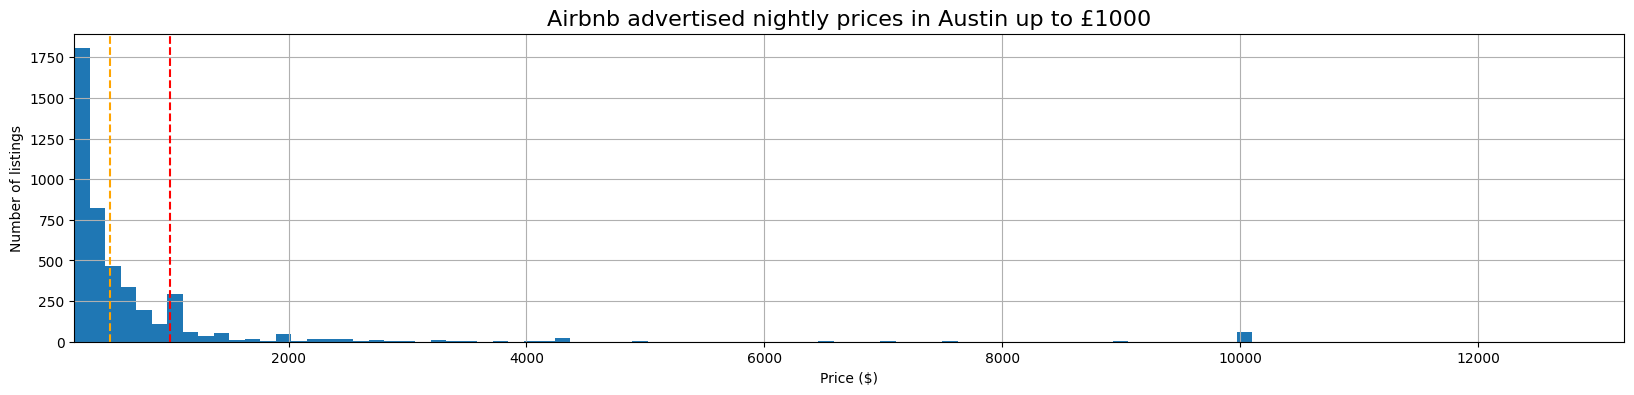

In [92]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Austin up to £1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [93]:
# Replacing values under $10 with $10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
df.loc[df.price >= 1000, 'price'] = 1000

In [94]:
df

host_response_time host_response_rate  host_is_superhost  \
0          within an hour               100%                1.0   
1      within a few hours               100%                1.0   
2      within a few hours               100%                1.0   
3      within a few hours               100%                1.0   
4          within an hour               100%                1.0   
...                   ...                ...                ...   
11787             unknown            unknown                0.0   
11788             unknown            unknown                0.0   
11789             unknown            unknown                0.0   
11790             unknown            unknown                0.0   
11791             unknown            unknown                0.0   

       host_listings_count  host_identity_verified                 hood  \
0                      3.0                     1.0  University of Texas   
1                      3.0                     1.0        East Downtown   
2                      3.0                     1.0        East Downtown   
3                      1.0                     1.0        East Downtown   
4                      1.0                     1.0    SW Williamson Co.   
...                    ...                     ...                  ...   
11787                  1.0                     0.0               Zilker   
11788                  2.0                     1.0              Hancock   
11789                  2.0                     0.0                  NaN   
11790                  1.0                     0.0       South Congress   
11791                  1.0                     1.0  University of Texas   

      property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0             Other  Entire home/apt             2        1.0       1.0   1.0   
1             House  Entire home/apt             4        2.0       2.0   2.0   
2             House     Private room             2        1.0       1.0   1.0   
3             Other  Entire home/apt             3        1.0       1.0   2.0   
4             House     Private room             2        1.0       1.0   1.0   
...             ...              ...           ...        ...       ...   ...   
11787         House     Private room             2        1.0       1.0   1.0   
11788     Apartment     Private room             1        1.0       1.0   1.0   
11789         House     Private room             1        1.5       1.0   1.0   
11790     Apartment  Entire home/apt             3        1.0       1.0   2.0   
11791     Apartment  Entire home/apt             2        1.0       1.0   1.0   

       price  security_deposit  cleaning_fee  guests_included  extra_people  \
0         85                 0            35                2           125   
1        225               500           100                4            30   
2        100               500            75                2            35   
3         95               100             0                2            45   
4         40                 0             0                2             0   
...      ...               ...           ...              ...           ...   
11787    150                 0             0                1             0   
11788     29                 0             0                1             0   
11789     30                 0             0                1             0   
11790    115                 0            50                2            25   
11791     90                 0             0                1             0   

       minimum_nights  maximum_nights  availability_90  number_of_reviews  \
0                   2             365               26                221   
1                  28             183               56                 24   
2                  28             180               41                  9   
3                   2              90               54                4

**host_listings_count**

The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is higher (34) due to some hosts managing some (very) large numbers of listings, as discussed above in the Time Series section. About half of listings are from hosts with one listing, and half are from multi-listing hosts.

In [95]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 34
54% of listings are from hosts with one listing.


**Number of people accommodated, bathrooms, bedrooms, and beds**

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

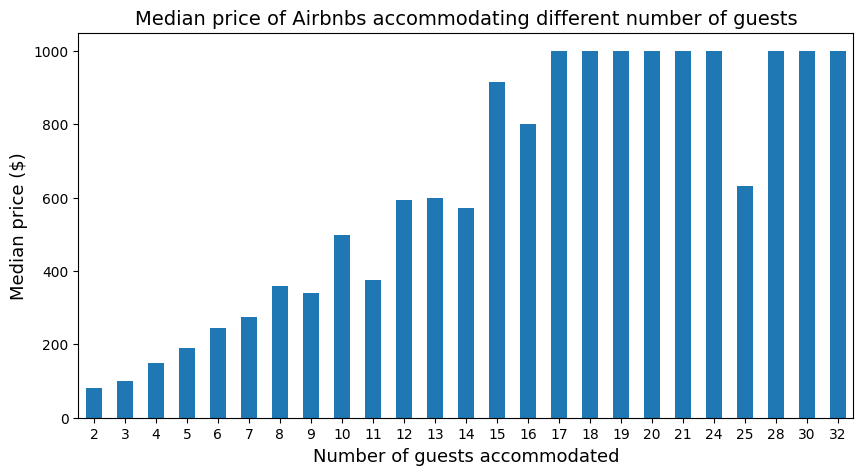

In [96]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

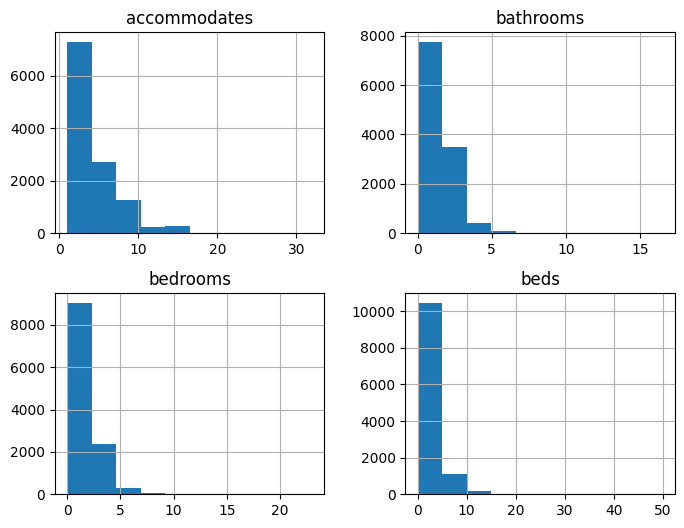

In [97]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [98]:
df.hood.value_counts()

East Downtown                 1124
Downtown                       640
Travis Heights                 484
University of Texas            411
Zilker                         388
East Riverside                 360
Bouldin Creek                  356
Barton Hills                   310
South Lamar                    307
Cherry Creek                   284
MLK & 183                      264
Upper Boggy Creek              236
McKinney                       222
Old West Austin                203
North Loop                     197
South Congress                 178
Govalle                        174
Hancock                        168
West Congress                  162
Westlake Hills                 161
Mueller                        160
Hyde Park                      158
Holly                          153
South Manchaca                 151
Rosewood                       151
West Campus                    150
Parker Lane                    144
Pleasant Valley                144
Windsor Park        

# **Categorical features**

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

In [100]:
# Renaming the neighbourhood column
df.rename(columns={'hood': 'borough'}, inplace=True)

# Importing the Austin borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('austin.geojson')
map_df.head()

name  cartodb_id                       created_at  \
0      Blackland           1 2013-02-17 09:28:09.692000+00:00   
1  Bouldin Creek           2 2013-02-17 09:28:09.692000+00:00   
2      Brentwood           3 2013-02-17 09:28:09.692000+00:00   
3     Cherrywood           4 2013-02-17 09:28:09.692000+00:00   
4       Chestnut           5 2013-02-17 09:28:09.692000+00:00   

                        updated_at  \
0 2013-02-17 09:28:09.956000+00:00   
1 2013-02-17 09:28:09.956000+00:00   
2 2013-02-17 09:28:09.956000+00:00   
3 2013-02-17 09:28:09.956000+00:00   
4 2013-02-17 09:28:09.956000+00:00   

                                            geometry  
0  MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...  
1  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  
2  MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...  
3  MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...  
4  MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...

In [101]:
# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('name').join(borough_df)

borough_map_df.head()

cartodb_id                       created_at  \
name                                                         
Blackland               1 2013-02-17 09:28:09.692000+00:00   
Bouldin Creek           2 2013-02-17 09:28:09.692000+00:00   
Brentwood               3 2013-02-17 09:28:09.692000+00:00   
Cherrywood              4 2013-02-17 09:28:09.692000+00:00   
Chestnut                5 2013-02-17 09:28:09.692000+00:00   

                                    updated_at  \
name                                             
Blackland     2013-02-17 09:28:09.956000+00:00   
Bouldin Creek 2013-02-17 09:28:09.956000+00:00   
Brentwood     2013-02-17 09:28:09.956000+00:00   
Cherrywood    2013-02-17 09:28:09.956000+00:00   
Chestnut      2013-02-17 09:28:09.956000+00:00   

                                                        geometry  \
name                                                               
Blackland      MULTIPOLYGON (((-97.72409 30.27926, -97.72514 ...   
Bouldin Creek  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...   
Brentwood      MULTIPOLYGON (((-97.72354 30.33038, -97.72371 ...   
Cherrywood     MULTIPOLYGON (((-97.70711 30.28920, -97.70700 ...   
Chestnut       MULTIPOLYGON (((-97.71991 30.27379, -97.72010 ...   

               number_of_listings  median_price  
name                                             
Blackland                     NaN           NaN  
Bouldin Creek               356.0         212.0  
Brentwood                   128.0          98.5  
Cherrywood                    NaN           NaN  
Chestnut                      NaN           NaN

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


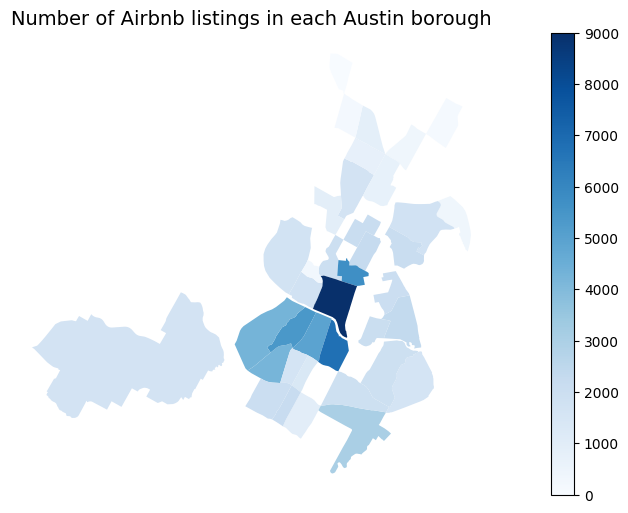

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


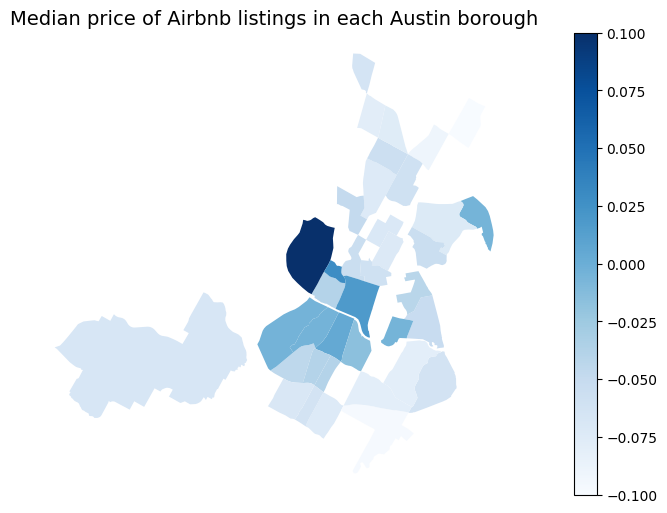

In [102]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Austin borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Austin borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [103]:
df.drop(['geometry'], axis=1, inplace=True)

**Property and room types**

In [104]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

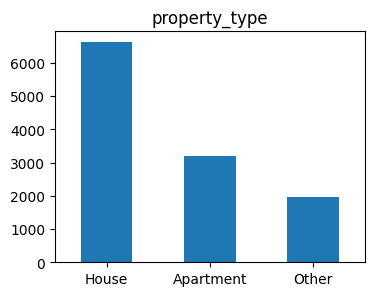

House        0.561313
Apartment    0.272049
Other        0.166638
Name: property_type, dtype: float64


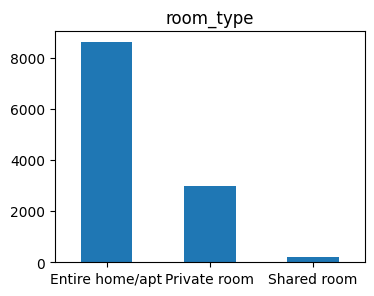

Entire home/apt    0.729393
Private room       0.254495
Shared room        0.016113
Name: room_type, dtype: float64


In [105]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

**Reviews**

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall) - clearly, people love their Airbnbs. Ratings of 8 or below are rare. Guests seem to be most positive about communication, check-ins, and accuracy. As noted previously, about a quarter of listings have not yet been reviewed.

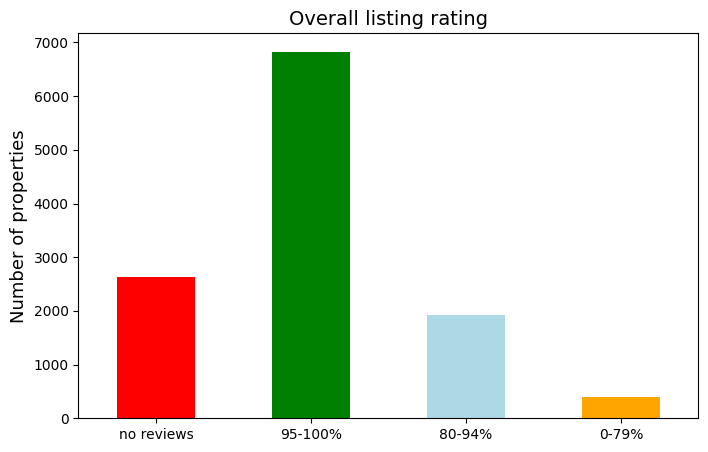

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['red', 'green', 'lightblue', 'orange' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

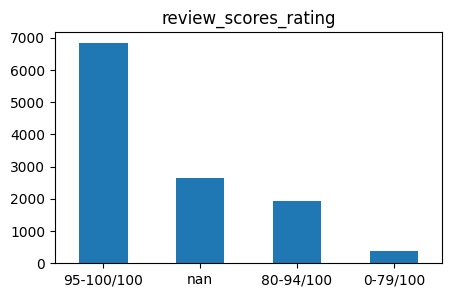

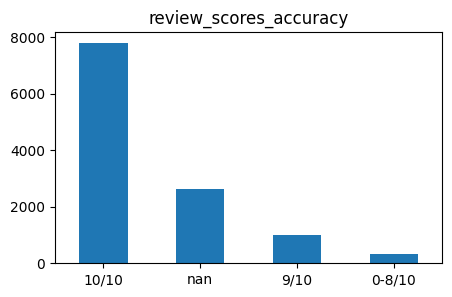

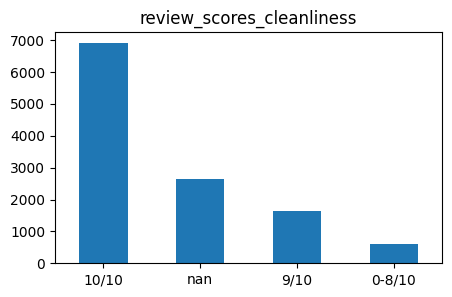

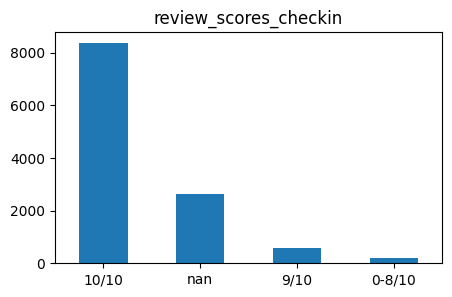

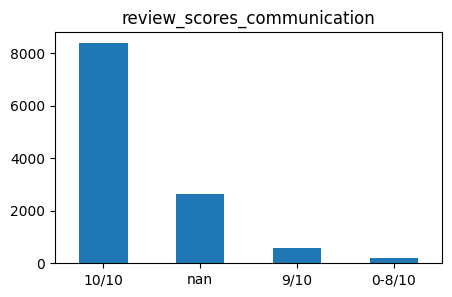

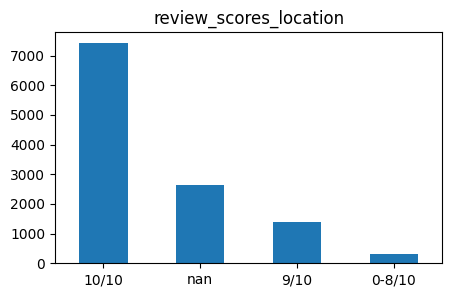

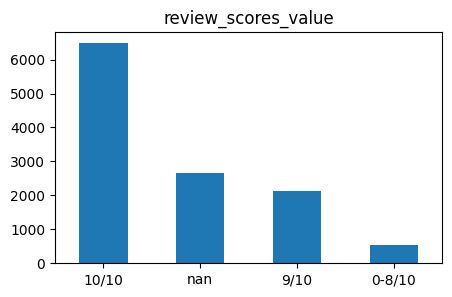

In [107]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

**First and last reviews**

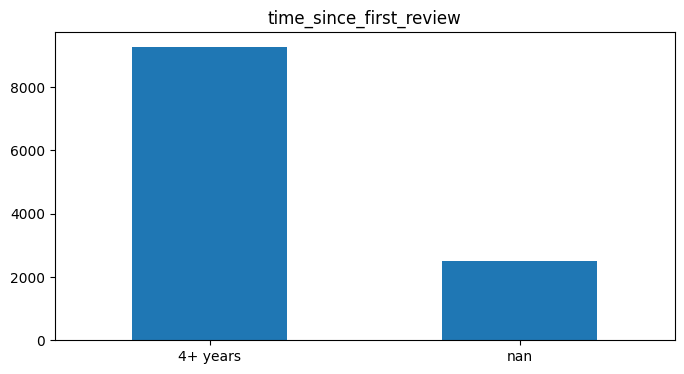

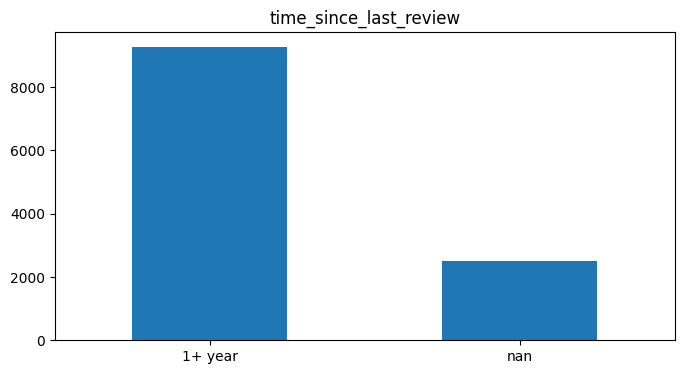

In [108]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### **Boolean (true or false) features**

Many features (e.g. for amenities) can be true or false.
This section compares the proportions of these features that are true or false
(to explore the data and also to ascertain whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).

In [109]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles

    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')

    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')

    plt.show()


**host_is_superhost**

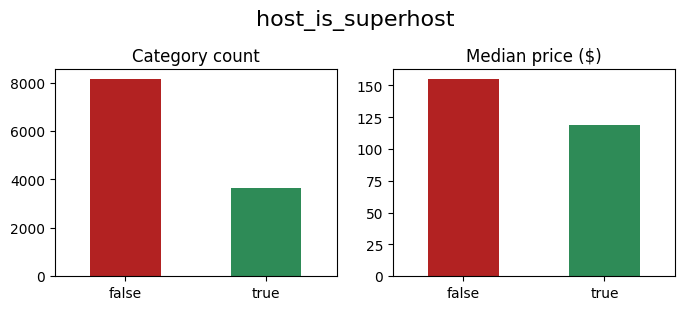

0.0    0.690389
1.0    0.309611
Name: host_is_superhost, dtype: float64


In [110]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

**host_identity_verified**

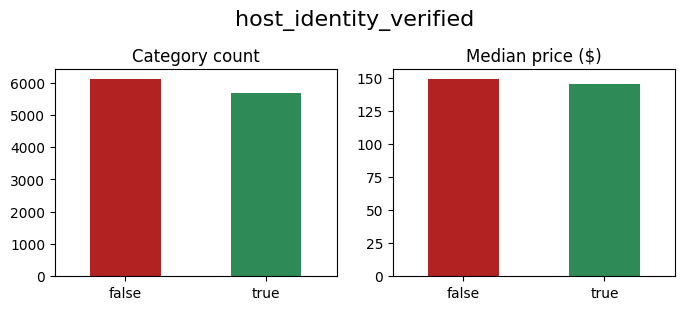

0.0    0.51828
1.0    0.48172
Name: host_identity_verified, dtype: float64

In [111]:
binary_count_and_price_plot('host_identity_verified')
df.host_identity_verified.value_counts(normalize=True)

**instant_bookable**

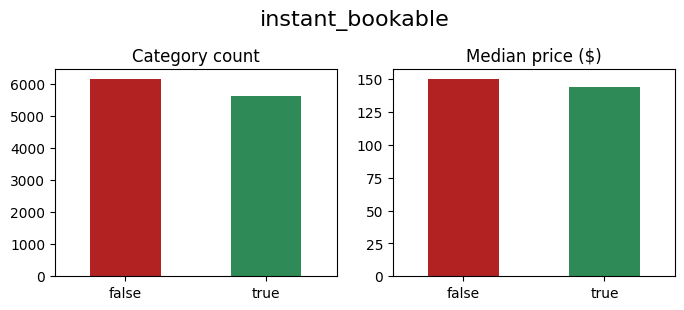

0    0.522388
1    0.477612
Name: instant_bookable, dtype: float64


In [112]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           11792 non-null  object 
 1   host_response_rate           11792 non-null  object 
 2   host_is_superhost            11789 non-null  float64
 3   host_listings_count          11789 non-null  float64
 4   host_identity_verified       11789 non-null  float64
 5   borough                      10965 non-null  object 
 6   property_type                11792 non-null  object 
 7   room_type                    11792 non-null  object 
 8   accommodates                 11792 non-null  int64  
 9   bathrooms                    11792 non-null  float64
 10  bedrooms                     11792 non-null  float64
 11  beds                         11792 non-null  float64
 12  price                        11792 non-null  int64  
 13  security_deposit

**Amenities**

Detecting amenities that have influenced the median price.

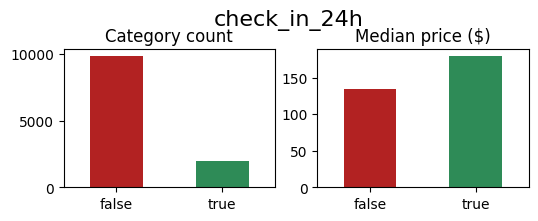

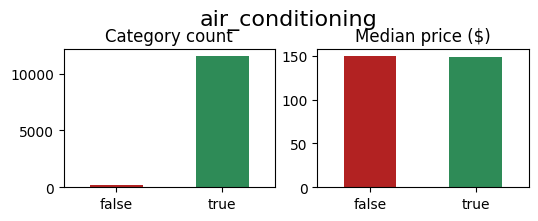

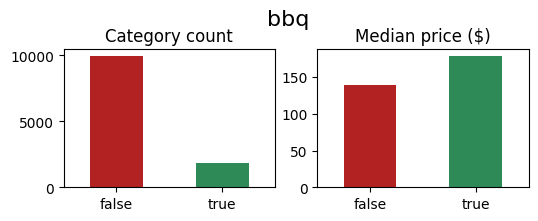

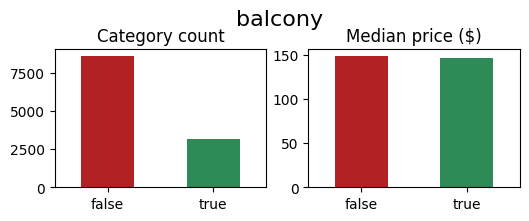

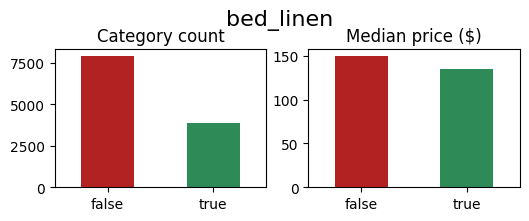

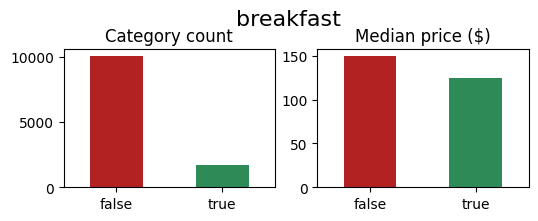

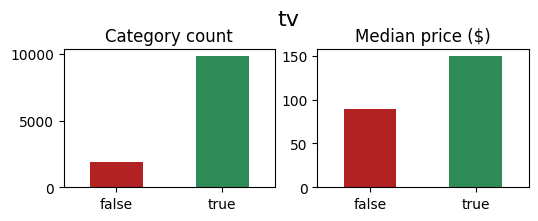

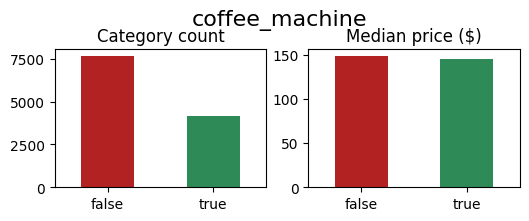

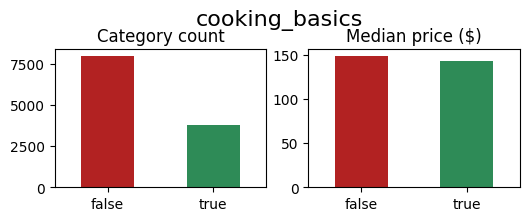

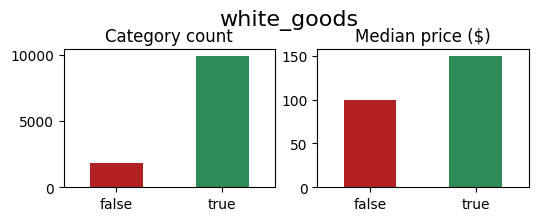

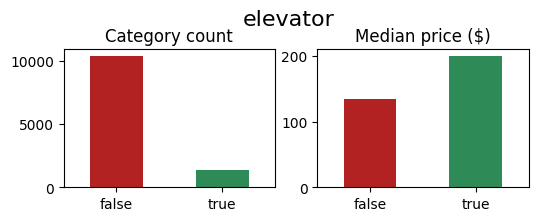

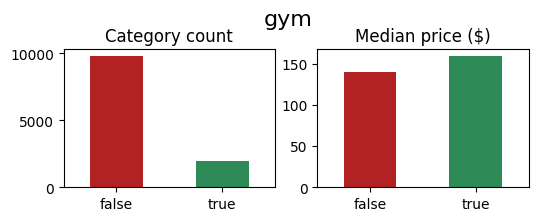

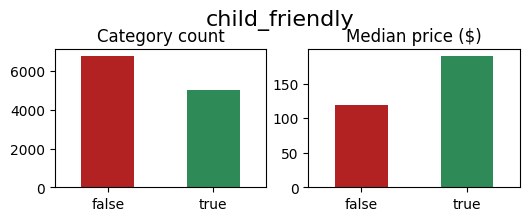

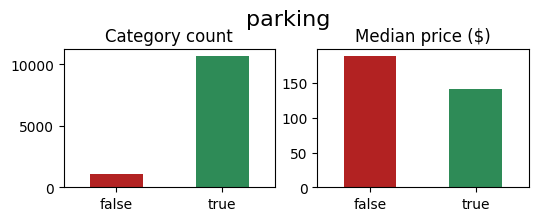

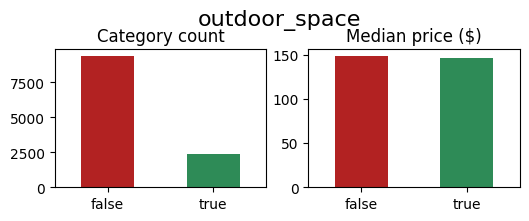

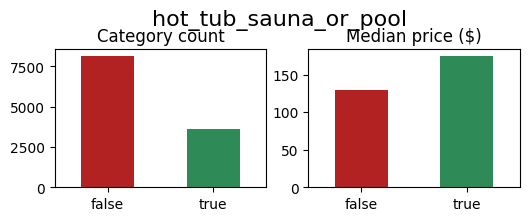

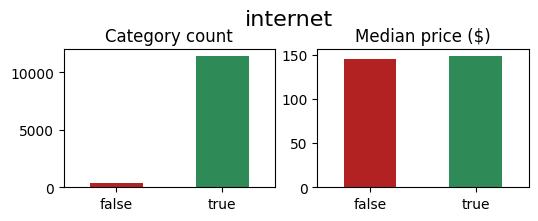

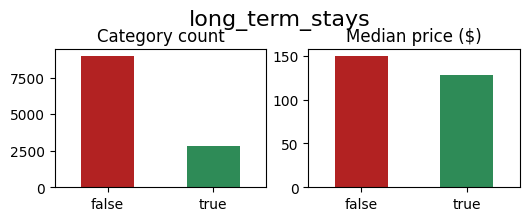

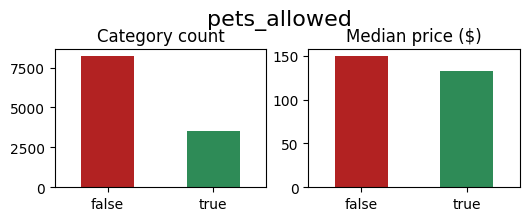

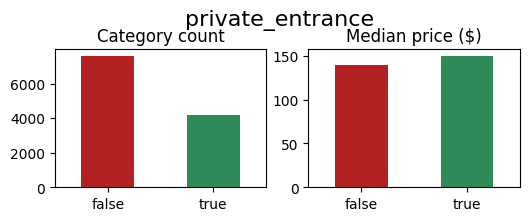

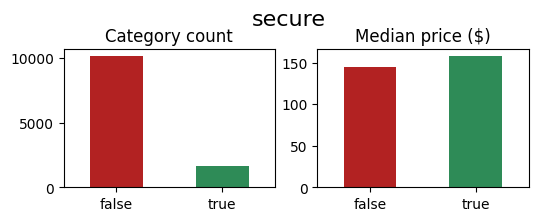

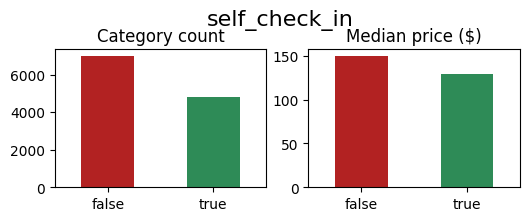

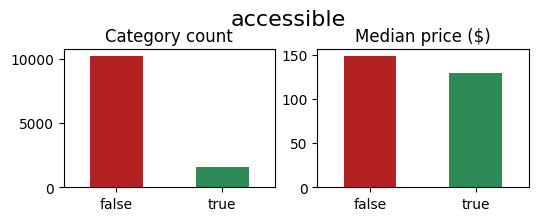

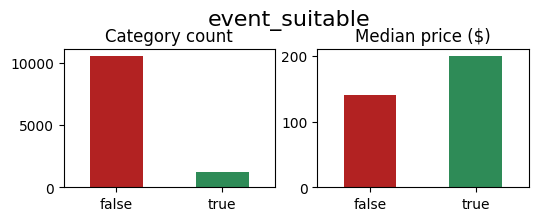

In [115]:
for col in df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           11792 non-null  object 
 1   host_response_rate           11792 non-null  object 
 2   host_is_superhost            11789 non-null  float64
 3   host_listings_count          11789 non-null  float64
 4   host_identity_verified       11789 non-null  float64
 5   borough                      10965 non-null  object 
 6   property_type                11792 non-null  object 
 7   room_type                    11792 non-null  object 
 8   accommodates                 11792 non-null  int64  
 9   bathrooms                    11792 non-null  float64
 10  bedrooms                     11792 non-null  float64
 11  beds                         11792 non-null  float64
 12  price                        11792 non-null  int64  
 13  security_deposit

### **Preparing the data for modeling**

Categorical variables will now be Label encoded:

In [117]:
le = LabelEncoder()
df['host_response_time'] = le.fit_transform(df['host_response_time'])
df['host_response_rate'] = le.fit_transform(df['host_response_rate'])
df['property_type'] = le.fit_transform(df['property_type'])
df['room_type'] = le.fit_transform(df['room_type'])
df['review_scores_rating'] = le.fit_transform(df['review_scores_rating'])
df['review_scores_accuracy'] = le.fit_transform(df['review_scores_accuracy'])
df['review_scores_cleanliness'] = le.fit_transform(df['review_scores_cleanliness'])
df['review_scores_checkin'] = le.fit_transform(df['review_scores_checkin'])
df['review_scores_communication'] = le.fit_transform(df['review_scores_communication'])
df['review_scores_location'] = le.fit_transform(df['review_scores_location'])
df['review_scores_value'] = le.fit_transform(df['review_scores_value'])
df['cancellation_policy'] = le.fit_transform(df['cancellation_policy'])
df['time_since_first_review'] = le.fit_transform(df['time_since_first_review'])
df['time_since_last_review'] = le.fit_transform(df['time_since_last_review'])
df['borough'] = le.fit_transform(df['borough'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           11792 non-null  int64  
 1   host_response_rate           11792 non-null  int64  
 2   host_is_superhost            11789 non-null  float64
 3   host_listings_count          11789 non-null  float64
 4   host_identity_verified       11789 non-null  float64
 5   borough                      11792 non-null  int64  
 6   property_type                11792 non-null  int64  
 7   room_type                    11792 non-null  int64  
 8   accommodates                 11792 non-null  int64  
 9   bathrooms                    11792 non-null  float64
 10  bedrooms                     11792 non-null  float64
 11  beds                         11792 non-null  float64
 12  price                        11792 non-null  int64  
 13  security_deposit

**Dropping columns and assessing multi-collinearity**

In [118]:
def multi_collinearity_heatmap(df, figsize=(11,9)):

    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """

    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());


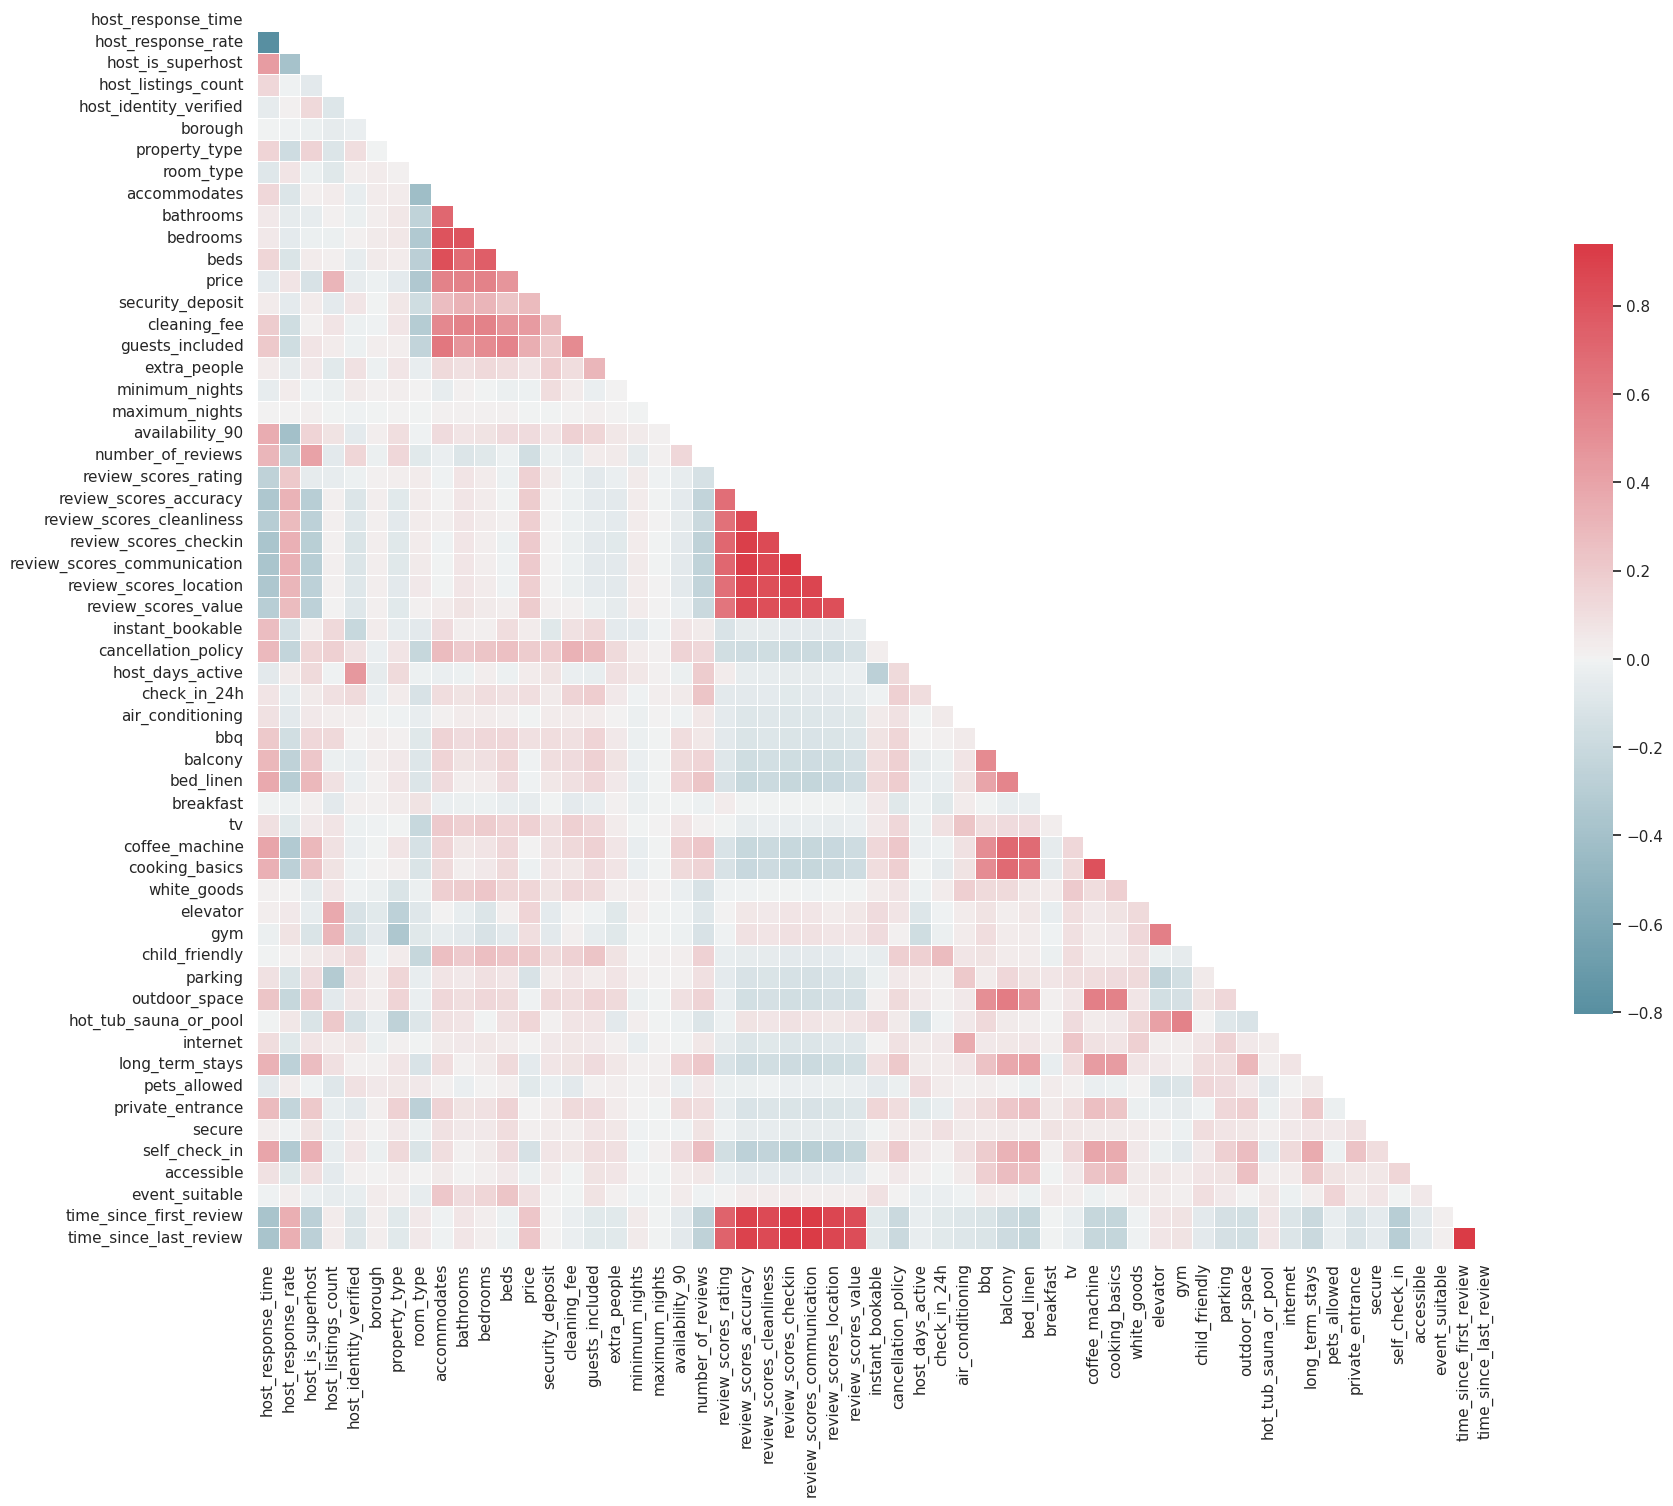

In [119]:
multi_collinearity_heatmap(df, figsize=(20,20))

In [120]:
# Dropping collinear features
df.drop(['bathrooms', 'bedrooms', 'beds', 'guests_included', 'review_scores_cleanliness', 'review_scores_value', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_accuracy'],axis = 1, inplace = True)

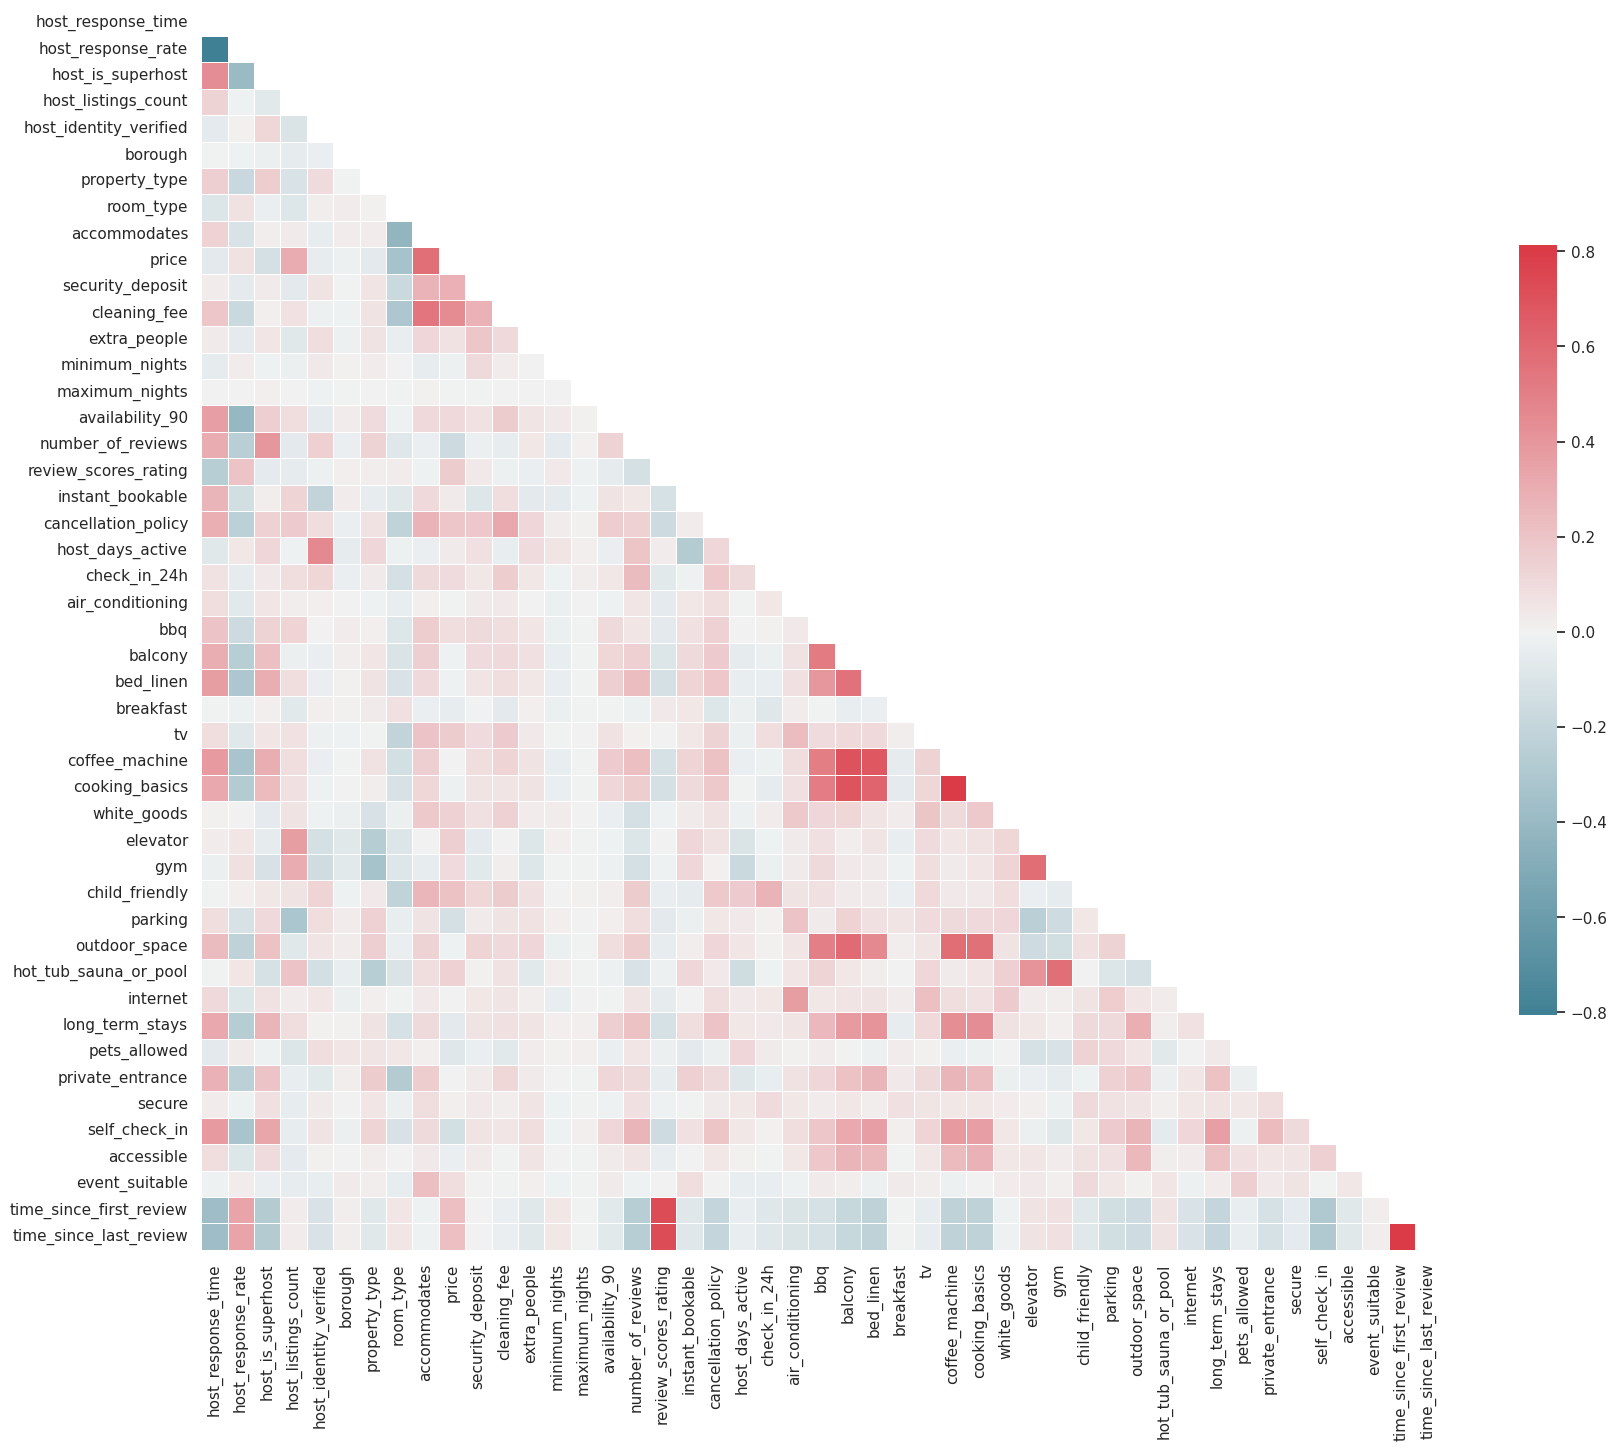

In [121]:
multi_collinearity_heatmap(df, figsize=(20,20))

In [122]:
# Final assessment of multi-collinearity
df.drop(['time_since_first_review', 'coffee_machine', 'bed_linen', 'balcony', 'tv', 'self_check_in'],axis = 1, inplace = True)

**Save the final cleaned version of the dataset.**

In [123]:
#Save the final version of our Dataset
with open('Final_df', 'wb') as f:
    pickle.dump(df, f)

### **Standardising and Normalising**

**Read the final cleaned version of the dataset.**

In [166]:
# Read the final version of our Dataset
with open('Final_df', 'rb') as f:
    df = pickle.load(f)
df

host_response_time  host_response_rate  host_is_superhost  \
0                       4                   1                1.0   
1                       3                   1                1.0   
2                       3                   1                1.0   
3                       3                   1                1.0   
4                       4                   1                1.0   
...                   ...                 ...                ...   
11787                   1                   4                0.0   
11788                   1                   4                0.0   
11789                   1                   4                0.0   
11790                   1                   4                0.0   
11791                   1                   4                0.0   

       host_listings_count  host_identity_verified  borough  property_type  \
0                      3.0                     1.0       66              2   
1                      3.0                     1.0       21              1   
2                      3.0                     1.0       21              1   
3                      1.0                     1.0       21              2   
4                      1.0                     1.0       53              1   
...                    ...                     ...      ...            ...   
11787                  1.0                     0.0       77              1   
11788                  2.0                     1.0       28              0   
11789                  2.0                     0.0       78              1   
11790                  1.0                     0.0       55              0   
11791                  1.0                     1.0       66              0   

       room_type  accommodates  price  security_deposit  cleaning_fee  \
0              0             2     85                 0            35   
1              0             4    225               500           100   
2              1             2    100               500            75   
3              0             3     95               100             0   
4              1             2     40                 0             0   
...          ...           ...    ...               ...           ...   
11787          1             2    150                 0             0   
11788          1             1     29                 0             0   
11789          1             1     30                 0             0   
11790          0             3    115                 0            50   
11791          0             2     90                 0             0   

       extra_people  minimum_nights  maximum_nights  availability_90  \
0               125               2             365               26   
1                30              28             183               56   
2                35              28             180               41   
3                45               2              90               54   
4                 0               1              14               69   
...             ...             ...             ...              ...   
11787             0               2            1125               80   
11788             0               1            1125               17   
11789             0               1               3               12   
11790            25               1              90               45   
11791             0              14            1125               82   

       number_of_reviews  review_scores_rating  instant_bookable  \
0                    221                     2                 1   
1                     24                     1                 0   
2                      9                     1                 0   
3                    481                     2                 0   
4                    246                     2                 0   
...                  ...                   ...               ...   
11787                  0           

Check the skewness of the data, to benefit from log transformation, in case of detecting skewness in features.

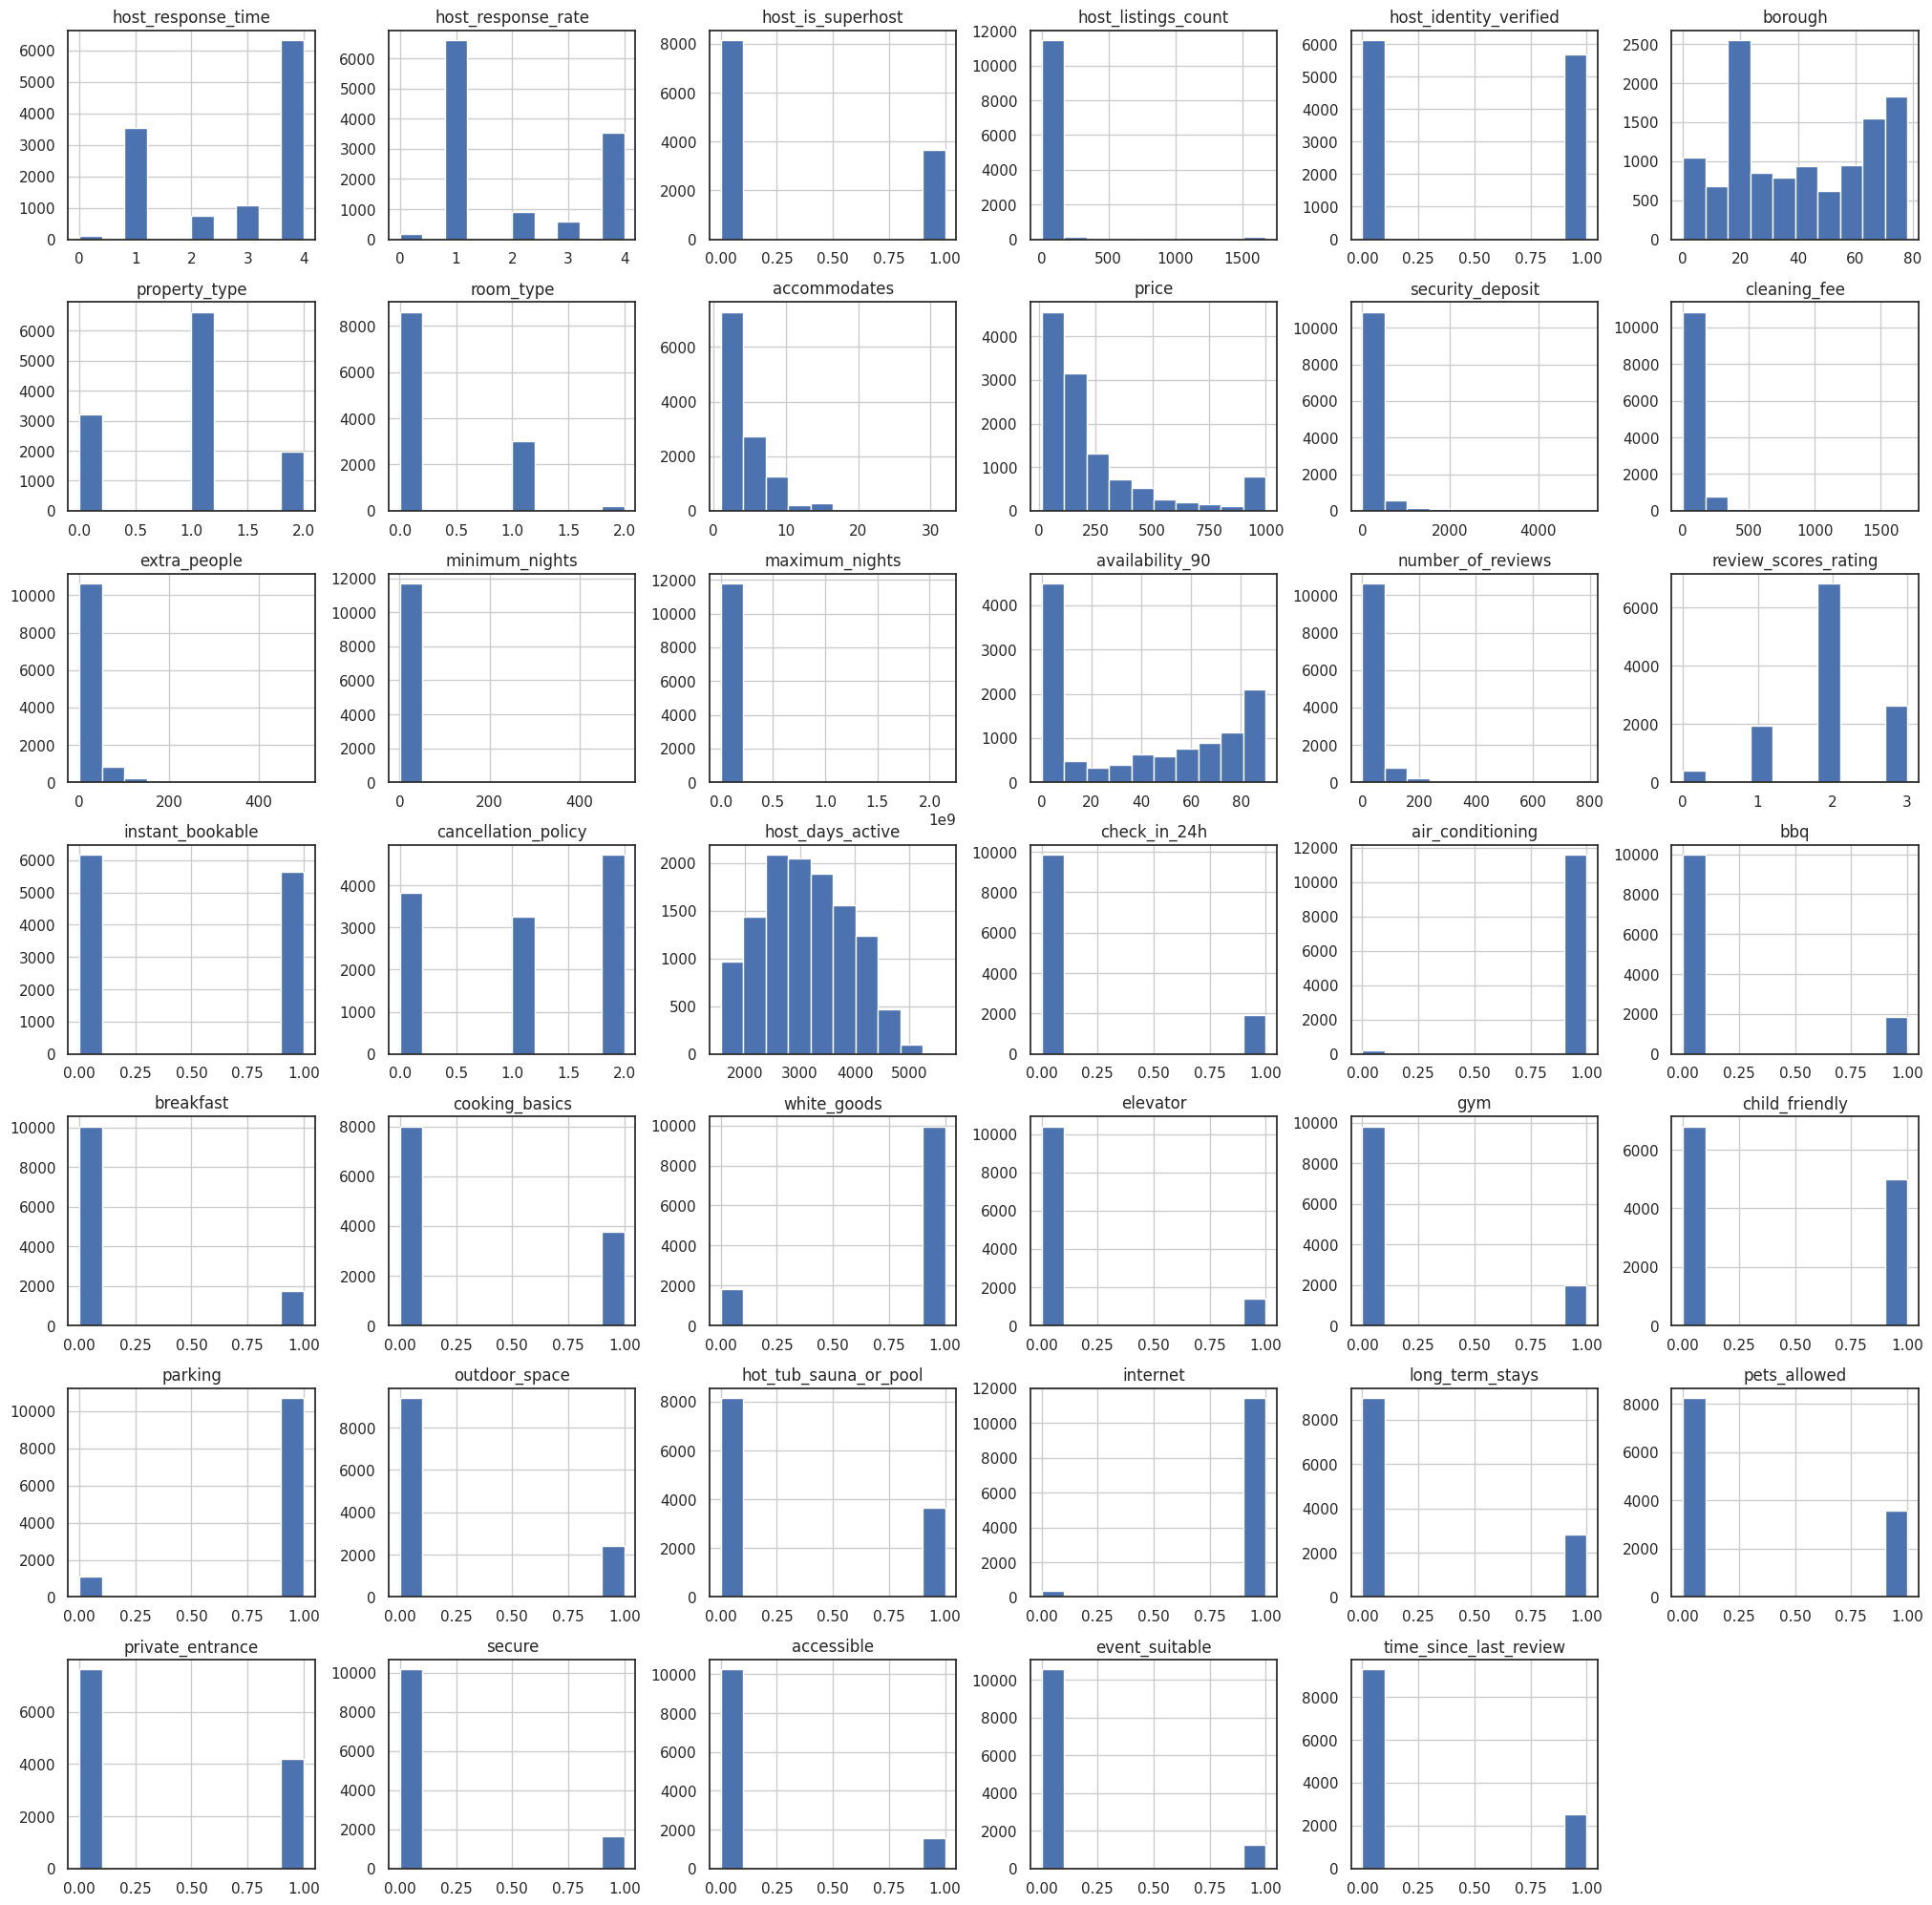

In [167]:
df.hist(figsize=(25,25));

<Figure size 2000x1200 with 0 Axes>

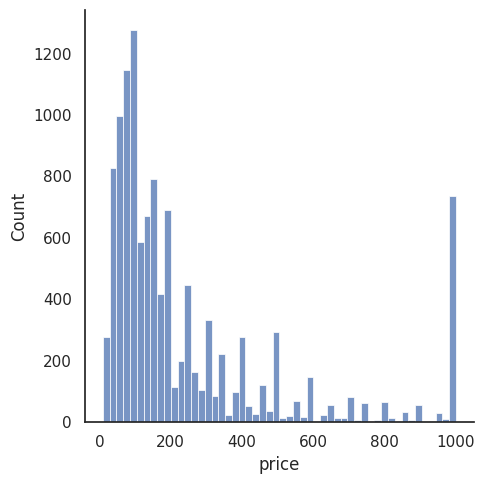

In [168]:
plt.figure(figsize=(20, 12))
sns.displot(df['price'])

In [169]:
# Log transforming columns
columns = ['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified', 'borough',
       'property_type', 'room_type', 'accommodates', 'price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy',
       'host_days_active', 'check_in_24h', 'air_conditioning', 'bbq',
        'breakfast', 'cooking_basics', 'white_goods',
       'elevator', 'gym', 'child_friendly', 'parking', 'outdoor_space',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'accessible',
       'event_suitable', 'time_since_last_review']
columns = [i for i in columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.where(df[col] > 0, np.log(df[col]), np.log(0.01))

<Figure size 2000x1200 with 0 Axes>

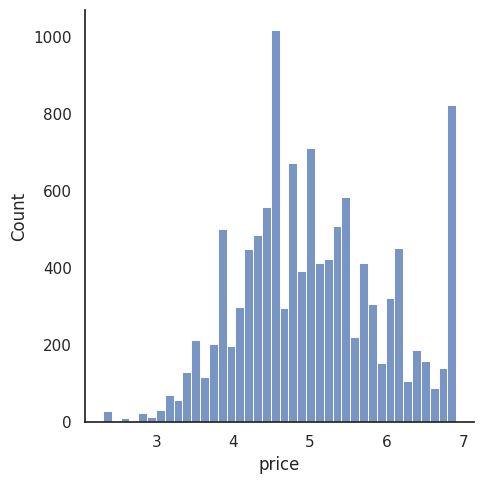

In [170]:
plt.figure(figsize=(20, 12))
sns.displot(df['price'])

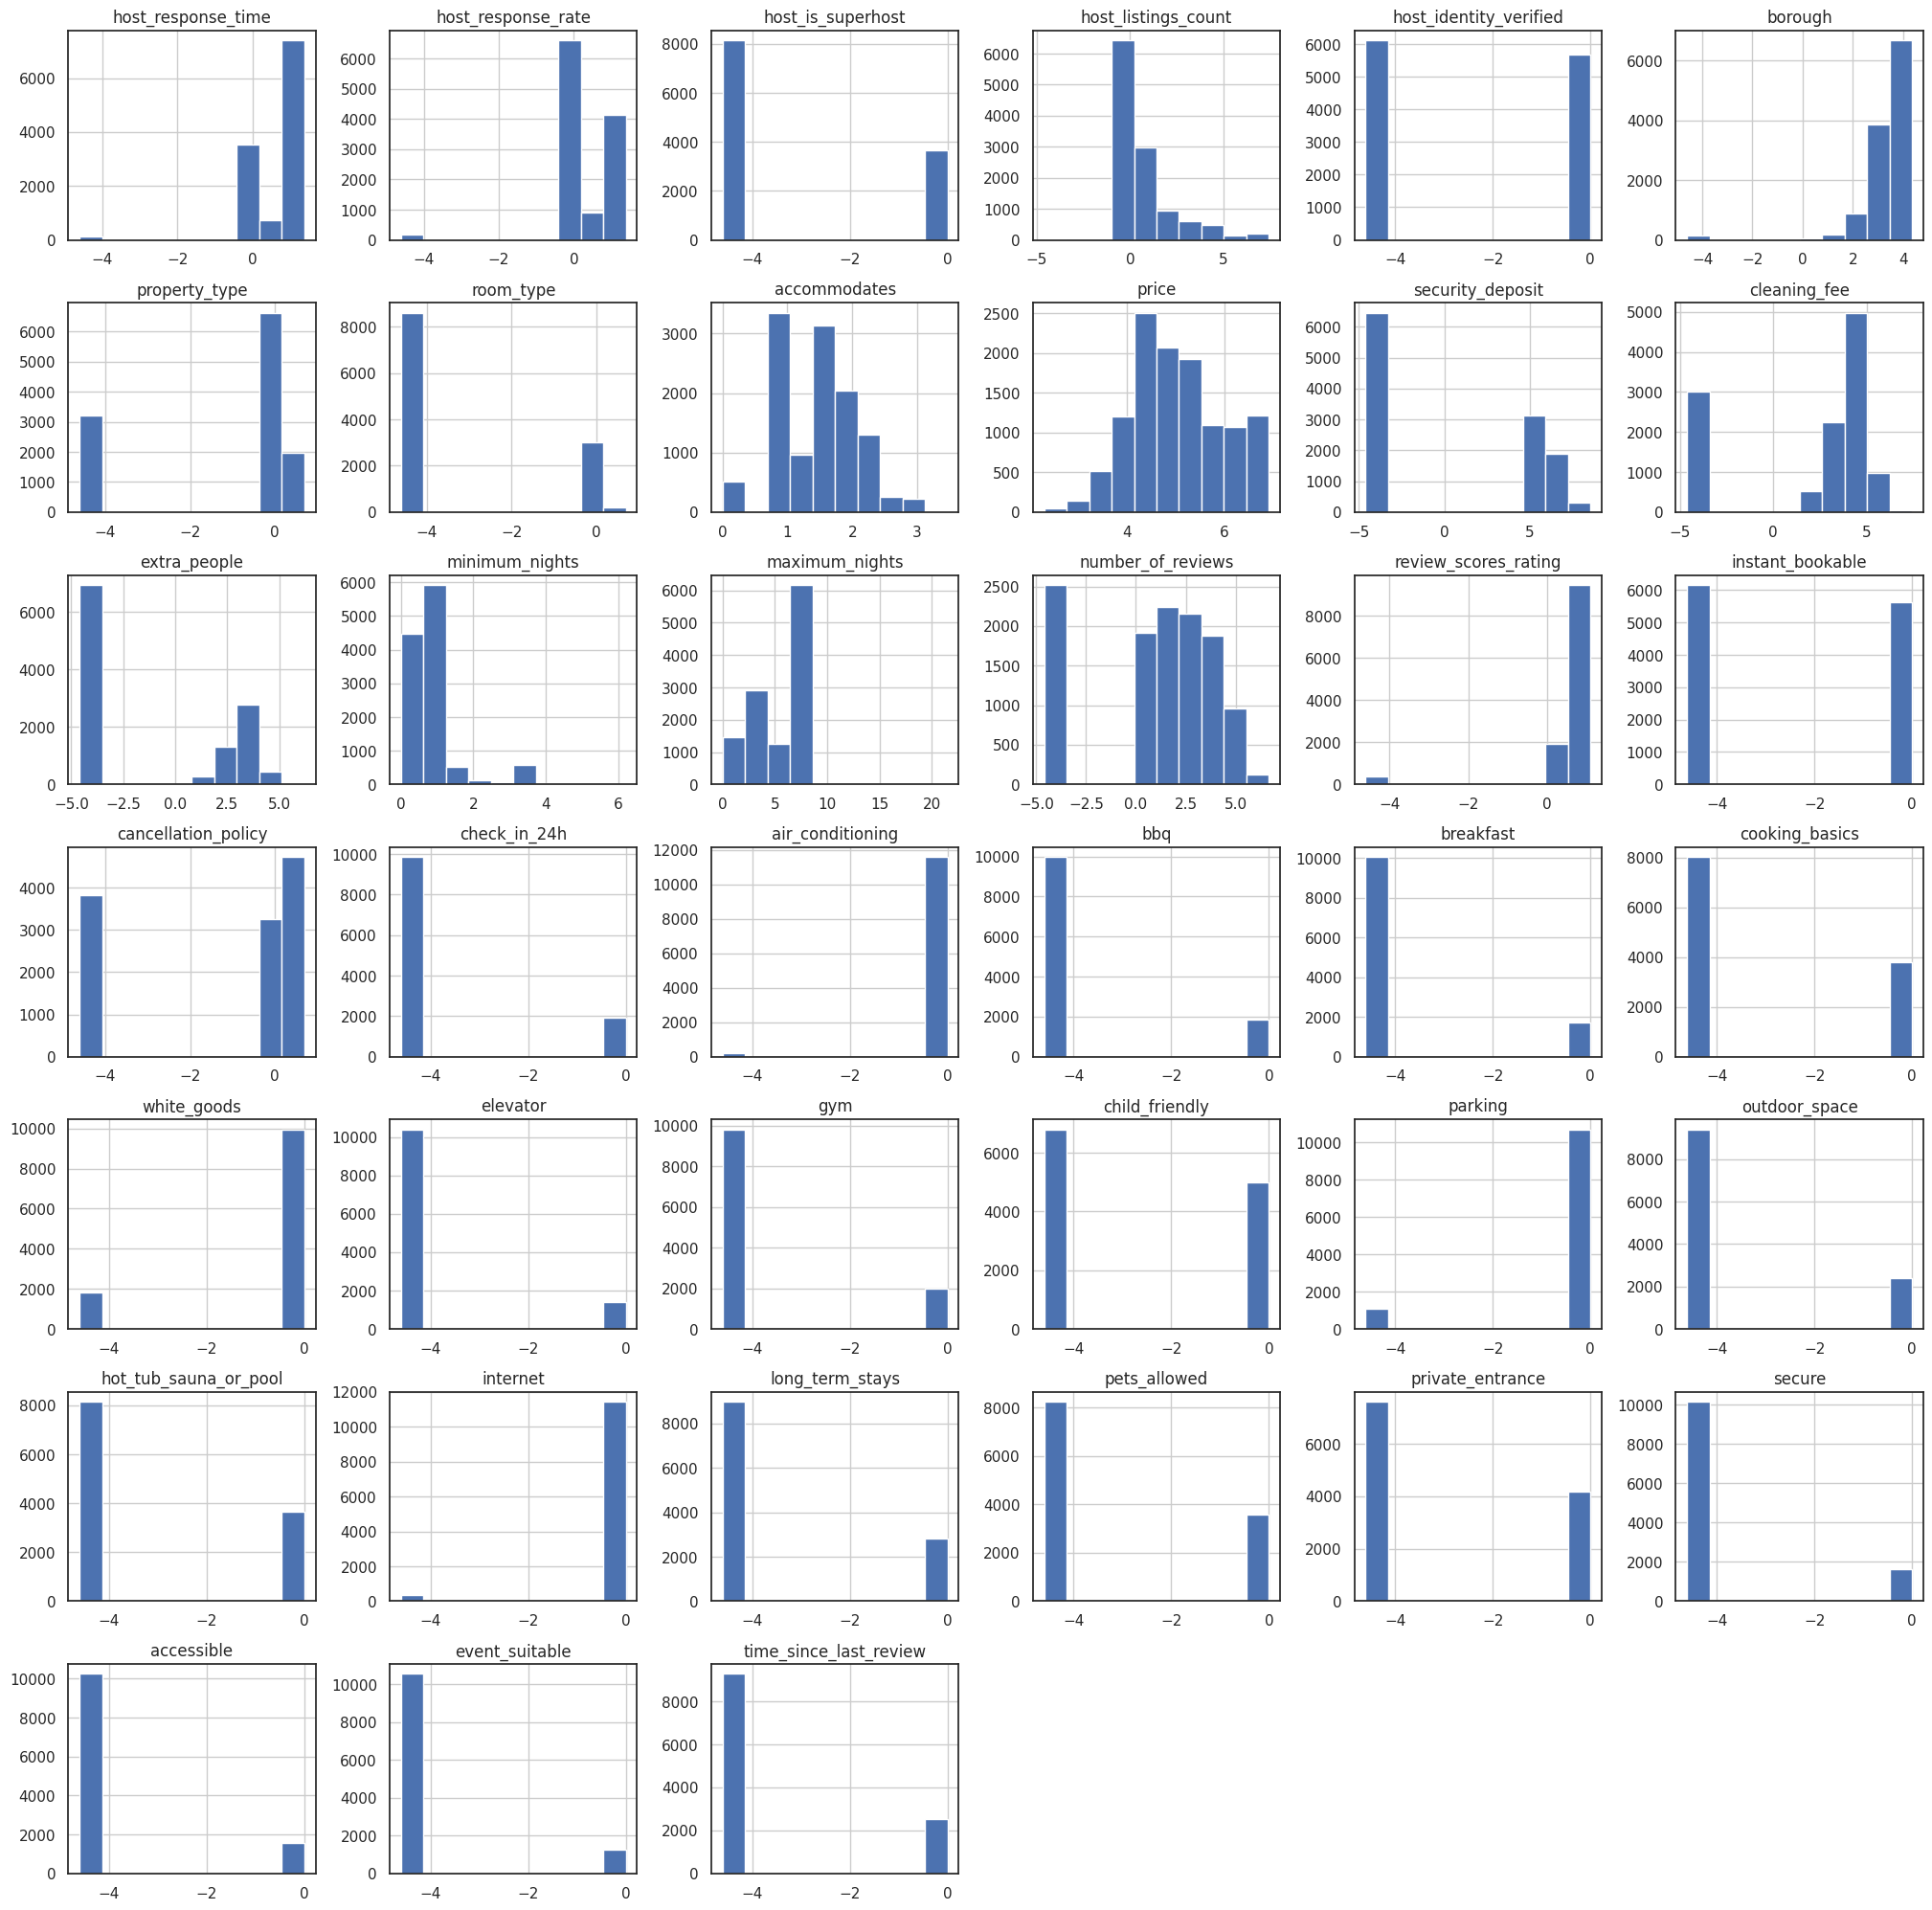

In [171]:
df[columns].hist(figsize=(25,25));

### **Building the Model using CatBoostRegressor**

Finally, the predictive features X and the target feature y can be separated, and X will be scaled.
StandardScaler from sklearn will be used.

In [172]:
# Separating X and y
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [173]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [174]:
# Scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))

In [175]:
model = cb.CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

Finding the optimal combination of hyper-parameters, using grid_search.

In [177]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)

{'params': {'depth': 6,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

bestTest = 0.4931268835

bestIteration = 199

In [178]:
np.exp(0.4931268835)

1.6374282708389059

In [179]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 0.50
R2: 0.74


<Figure size 2000x2000 with 0 Axes>

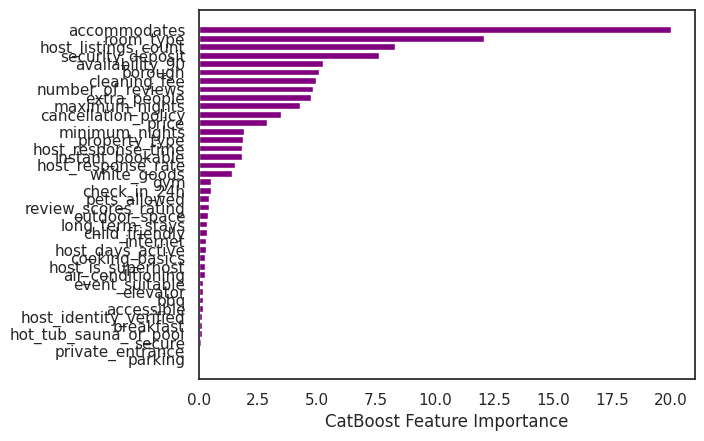

<Figure size 2000x2000 with 0 Axes>

In [180]:
# Plotting feature importances
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(df.columns[sorted_feature_importance],
        model.feature_importances_[sorted_feature_importance],
        color='purple')
plt.xlabel("CatBoost Feature Importance")
plt.figure(figsize=(20, 20))

 create a summary plot using the SHAP (SHapley Additive exPlanations) library

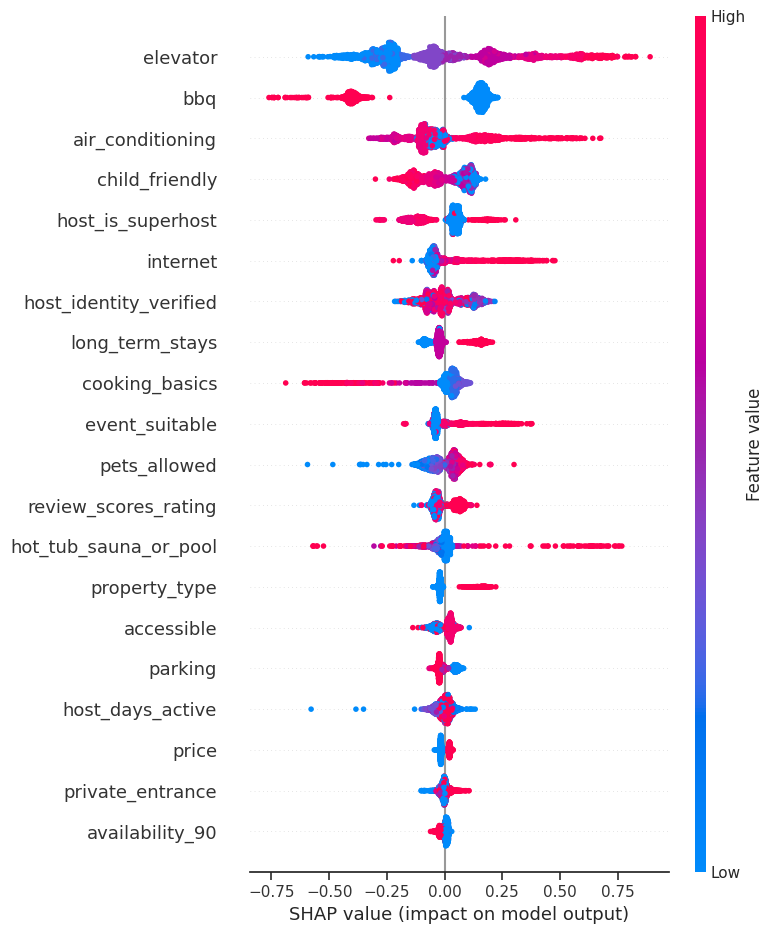

In [182]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df.columns[sorted_feature_importance], plot_type='dot')

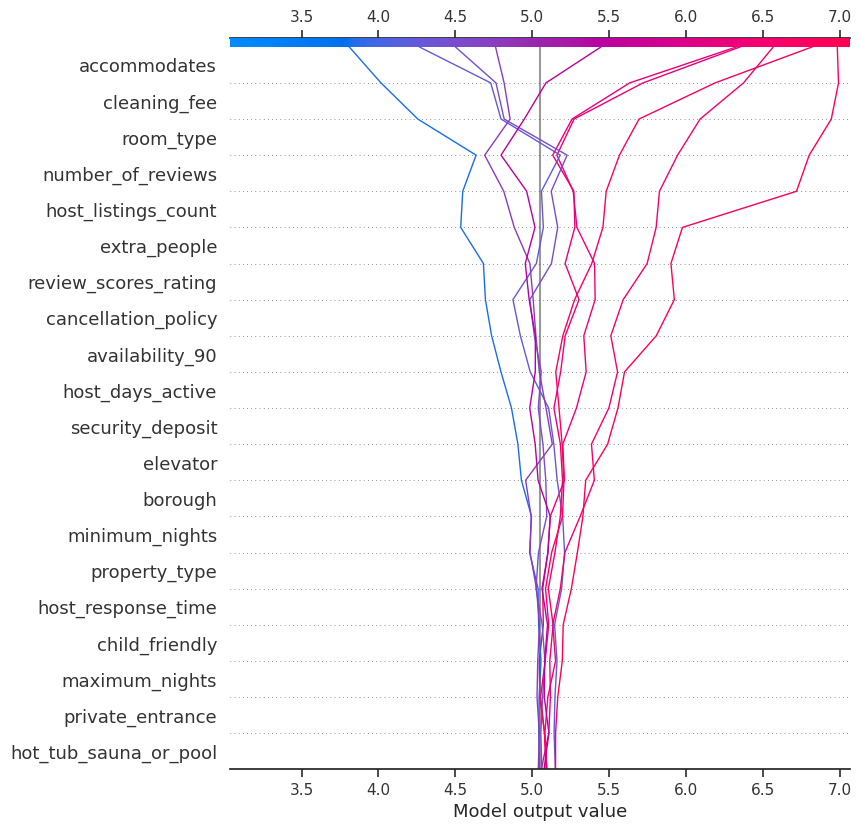

In [183]:
#Plot shap decision tree
expected_values = explainer.expected_value
shap_array = explainer.shap_values(X_test)

shap.decision_plot(expected_values, shap_array[0:10],feature_names=list(X_test.columns))

In the SHAP plot, the features are ranked based on their average absolute SHAP
and the colors represent the feature value (red high, blue low).
The higher the SHAP value, the larger the predictor’s attribution.
In other words, the SHAP values represent a predictor’s responsibility for a change in the model output.



---



---


The top 10 most important features are:

* How many people the property accommodates
* The room type
* The security deposit
* How many days are available to book out of the next 90
* How many other listings the host has (and whether they are a multi-listing host)
* The borough
* The fee per extra person
* The cleaning fee
* The maximum night stay
* The number of reviews


---



---

